# **Proyecto Orange** 
### **Responsables: Andrés Felipe Ocampo, Alejandra Ruiz y Luis Felipe Montenegro**

# **Librerías**

In [1]:
# --- Librerías estándar ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Estadística y pruebas ---
from scipy.stats import f_oneway, levene, shapiro, pearsonr
import scipy.stats as stats  # para otras funciones estadísticas

# --- Modelos y regresión ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import OrdinalEncoder

# --- Statsmodels para ANOVA y Tukey ---
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# --- Librerías específicas ---
import pingouin as pg  # pruebas estadísticas (e.g. kruskal, dunn)
from dython.nominal import identify_nominal_columns, identify_numeric_columns, correlation_ratio
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn.utils import resample
from scipy.stats import shapiro, probplot

# **Sección 1 - Cargue y transformación de dataset**

In [2]:
#Lectura de datos
df = pd.read_excel('prueba.xlsx', header=8)
pd.set_option('display.max_columns', None)

In [3]:
# Crear dataset para análisis
df_analysis = df.copy() 

# Renombrar columnas para facilitar análisis
df_analysis.rename(columns={
    '2 company size': 'Company size',
    '9 Last Year Sales': 'Last year sales',
    '3 Age of the company:': 'Age of company',
    '4 Geographic reach location:': 'Geographic reach location',
    '5 R&D Expenditure (Research and Development):': 'R&D expenditure',
    '6 new products sales:': 'New products sales',
    '7 Number of patents/innovations:': 'Number of patents innovations',
    '8 Annual growth:': 'Annual growth',
    "1 industry/sector:": "Industry/Sector"
}, inplace=True)

# Eliminar duplicados por empresa
df_analysis = df_analysis.drop_duplicates(subset=['Company'])

# Seleccionar columnas 1 a 15
df_analysis = df_analysis.iloc[:, 1:15]

# Dividir la columna de industria y sector
df_analysis[['Industry', 'Sector']] = df_analysis['Industry/Sector'].str.split(', ', n=1, expand=True)

# Limpiar y convertir 'New products sales'
df_analysis['New products sales'] = df_analysis['New products sales'].astype(str)
df_analysis['New products sales'] = df_analysis['New products sales'].str.replace(r'[\$,]', '', regex=True)
df_analysis['New products sales'] = df_analysis['New products sales'].str.replace('.', '', regex=False)
df_analysis['New products sales'] = df_analysis['New products sales'].astype(float)

# Cambiar a inglés los valores de las columnas "Industry" y "Sector"
# Diccionario de traducción
industry_translation = {
    "Manufactura": "Manufacturing",
    "Servicios": "Services",
    "Comercio": "Commerce"
}

sector_translation = {
    "Moda": "Fashion",
    "Construcción": "Construction",
    "Comidas y bebidas": "Food and Beverages",
    "Educación": "Education",
    "Automotor": "Automotive",
    "Belleza y cuidado personal": "Beauty and Personal Care",
    "Deportes": "Sports",
    "Empaques": "Packaging",
    "Energía": "Energy",
    "Ferroelectrico": "Ferroelectric",
    "Mejora de procesos": "Process Improvement",
    "Papelería": "Stationery",
    "Tecnología": "Technology",
    "Textiles": "Textiles",
    "Transporte y logística": "Transport and Logistics"
}

# Aplicar la traducción a Industry
df_analysis['Industry'] = df_analysis['Industry'].replace(industry_translation)

# Limpieza previa opcional: quitar espacios extra si hay
df_analysis['Sector'] = df_analysis['Sector'].str.strip()
# Unificar manualmente los duplicados (si hay diferencias de acento, mayúsculas, etc.)
df_analysis['Sector'] = df_analysis['Sector'].replace("Tecnología", "Tecnología")
# Aplicar traducción a sector
df_analysis['Sector'] = df_analysis['Sector'].replace(sector_translation)

# Cambiar a millones algunas variables
df_analysis['R&D expenditure (millions)']=df_analysis['R&D expenditure']/1_000_000
df_analysis['New products sales (millions)']=df_analysis['New products sales']/1_000_000
df_analysis['Last year sales (millions)']=df_analysis['Last year sales']/1_000_000

# Hacer transformación a porcentaje de variable "Annual growth"
df_analysis['Annual growth'] = df_analysis['Annual growth'].astype(float)
df_analysis['Annual growth (%)'] = (df_analysis['Annual growth'] * 100).round(1).astype(str) + '%'

# Vista previa
df_analysis.head(5)

,Company_number,LT \nLeader of Team)\n \nor\n \nTM \n(Team Member),CODE,Industry,Industry/Sector,Company size,Age of company,Age of the company (segment),Geographic reach location,R&D expenditure,New products sales,Number of patents innovations,Annual growth,Last year sales,Sector,R&D expenditure (millions),New products sales (millions),Last year sales (millions),Annual growth (%)
0,1,LT,C01-LT,Manufacturing,"Manufactura, Moda",Big,29,25+ years,Regional,2.000000e-02,1.785000e+10,12,0.18,85000000000,Fashion,2.000000e-08,17850.0,85000.0,18.0%
2,2,LT,C02-LT,Services,"Servicios, Comidas y bebidas",Big,6,5-8 years,National,1.037000e+09,2.835000e+09,8,0.24,94500000000,Food and Beverages,1.037000e+03,2835.0,94500.0,24.0%
4,3,LT,C03-LT,Manufacturing,"Manufactura, Moda",Big,8,5-8 years,Local,0.000000e+00,1.320000e+10,4,0.10,110000000000,Fashion,0.000000e+00,13200.0,110000.0,10.0%
6,4,LT,C04-LT,Services,"Servicios, Transporte y logística",Medium,23,15-25 years,International,1.200000e+09,4.800000e+09,6,0.15,13450000000,Transport and Logistics,1.200000e+03,4800.0,13450.0,15.0%
8,5,LT,C05-LT,Services,"Servicios, Tecnología",Medium,25,15-25 years,National,9.625000e+08,3.850000e+09,4,0.08,19250000000,Technology,9.625000e+02,3850.0,19250.0,8.0%


# **Sección 2 - Análisis Univariado**

## **2.1 Industry**

In [4]:
df_analysis['Industry'].describe()

count                28
unique                3
top       Manufacturing
freq                 14
Name: Industry, dtype: object

In [5]:
tabla_freq=(pd.crosstab(index=df_analysis["Industry"],columns="count")).reset_index()
tabla_freq['Freq. Rel.']=tabla_freq['count']/sum(tabla_freq['count'])
tabla_freq.rename(columns={'count':'Freq. Abs.'},inplace=True)
tabla_freq=tabla_freq.sort_values(by='Freq. Abs.',ascending=False).reset_index(drop=True)
tabla_freq

col_0,Industry,Freq. Abs.,Freq. Rel.
0,Manufacturing,14,0.500000
1,Services,8,0.285714
2,Commerce,6,0.214286


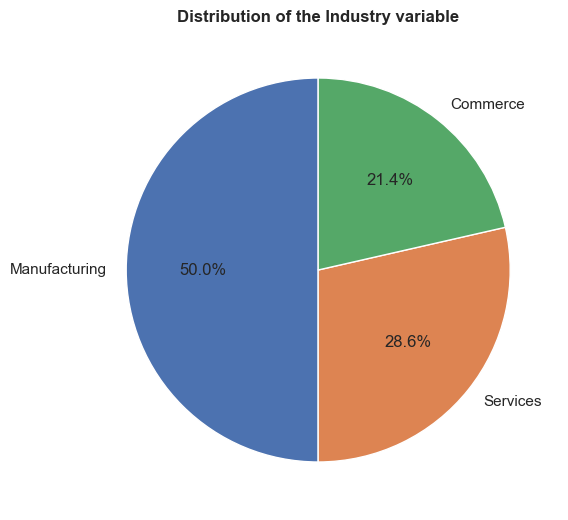

In [6]:
fig_torta = plt.figure() 
ax = fig_torta.add_axes([0,0,1,1])
plt.pie(tabla_freq["Freq. Rel."], labels=tabla_freq["Industry"],autopct='%1.1f%%',startangle=90)
plt.title("Distribution of the Industry variable", fontweight='bold')
plt.show()

## **2.2 Sector**

In [7]:
df_analysis['Sector'].describe()

count          28
unique         15
top       Fashion
freq            8
Name: Sector, dtype: object

In [8]:
tabla_freq=(pd.crosstab(index=df_analysis["Sector"],columns="count")).reset_index()
tabla_freq['Freq. Rel.']=tabla_freq['count']/sum(tabla_freq['count'])
tabla_freq.rename(columns={'count':'Freq. Abs.'},inplace=True)
tabla_freq=tabla_freq.sort_values(by='Freq. Abs.',ascending=False).reset_index(drop=True)
tabla_freq

col_0,Sector,Freq. Abs.,Freq. Rel.
0,Fashion,8,0.285714
1,Construction,4,0.142857
2,Education,2,0.071429
3,Food and Beverages,2,0.071429
4,Technology,2,0.071429
5,Automotive,1,0.035714
6,Beauty and Personal Care,1,0.035714
7,Energy,1,0.035714
8,Ferroelectric,1,0.035714
9,Packaging,1,0.035714


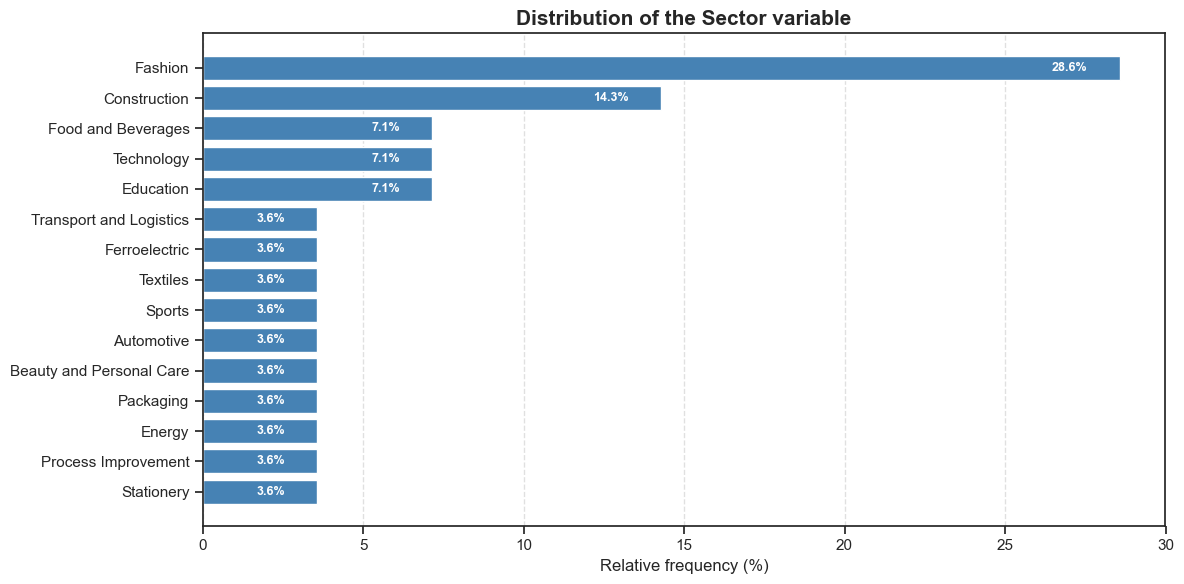

In [9]:
# Recalcular sector_freq_sorted por si se perdió en el contexto
sector_freq = df_analysis['Sector'].value_counts().reset_index()
sector_freq.columns = ['Sector', 'frecuencia_absoluta']
sector_freq['frecuencia_relativa'] = sector_freq['frecuencia_absoluta'] / sector_freq['frecuencia_absoluta'].sum()
sector_freq_sorted = sector_freq.sort_values(by="frecuencia_relativa", ascending=False)

# Crear el gráfico de barras con etiquetas al extremo derecho y en color blanco
fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(
    sector_freq_sorted["Sector"],
    sector_freq_sorted["frecuencia_relativa"] * 100,
    color="#4682B4"
)

# Añadir etiquetas en blanco al final de cada barra
for bar in bars:
    width = bar.get_width()
    ax.text(width - 1, bar.get_y() + bar.get_height() / 2,
            f"{width:.1f}%", va='center', ha='right', color='white', fontsize=9, fontweight='bold')

# Configuración estética
ax.set_xlabel("Relative frequency (%)")
ax.set_title("Distribution of the Sector variable", fontsize=15, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## **2.3 Age of the company**

In [10]:
df_analysis['Age of company'].describe()

count    28.000000
mean     19.142857
std      12.270755
min       5.000000
25%       7.750000
50%      17.500000
75%      25.500000
max      47.000000
Name: Age of company, dtype: float64

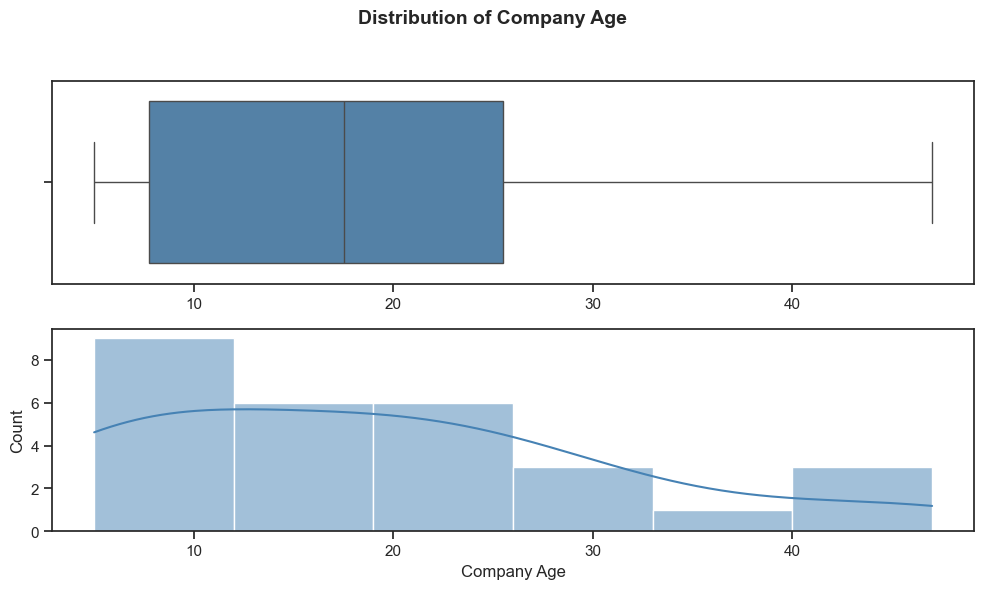

In [11]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("Distribution of Company Age",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['Age of company'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['Age of company'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("Company Age")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

## **2.4 Geographic location**

In [12]:
df_analysis['Geographic reach location'].describe()

count        28
unique        4
top       Local
freq         14
Name: Geographic reach location, dtype: object

In [13]:
tabla_freq=(pd.crosstab(index=df_analysis["Geographic reach location"],columns="count")).reset_index()
tabla_freq['Freq. Rel.']=tabla_freq['count']/sum(tabla_freq['count'])
tabla_freq.rename(columns={'count':'Freq. Abs.'},inplace=True)
tabla_freq=tabla_freq.sort_values(by='Freq. Abs.',ascending=False).reset_index(drop=True)
tabla_freq

col_0,Geographic reach location,Freq. Abs.,Freq. Rel.
0,Local,14,0.500000
1,National,9,0.321429
2,International,3,0.107143
3,Regional,2,0.071429


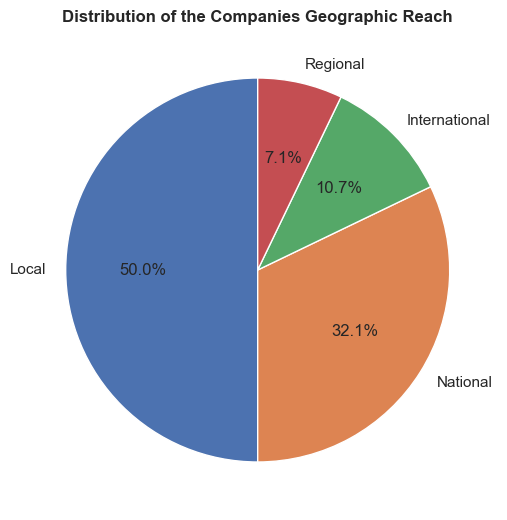

In [14]:
fig_pie = plt.figure() 
ax = fig_pie.add_axes([0, 0, 1, 1])

plt.pie(tabla_freq["Freq. Rel."],
        labels=tabla_freq["Geographic reach location"],
        autopct='%1.1f%%',
        startangle=90)

plt.title("Distribution of the Companies Geographic Reach", fontweight='bold')
plt.show()

## **2.5 R&D Expenditure**

In [15]:
df_analysis['R&D expenditure (millions)'].describe()

count      28.000000
mean      249.546429
std       428.326091
min         0.000000
25%         0.000000
50%        72.500000
75%       121.125000
max      1424.000000
Name: R&D expenditure (millions), dtype: float64

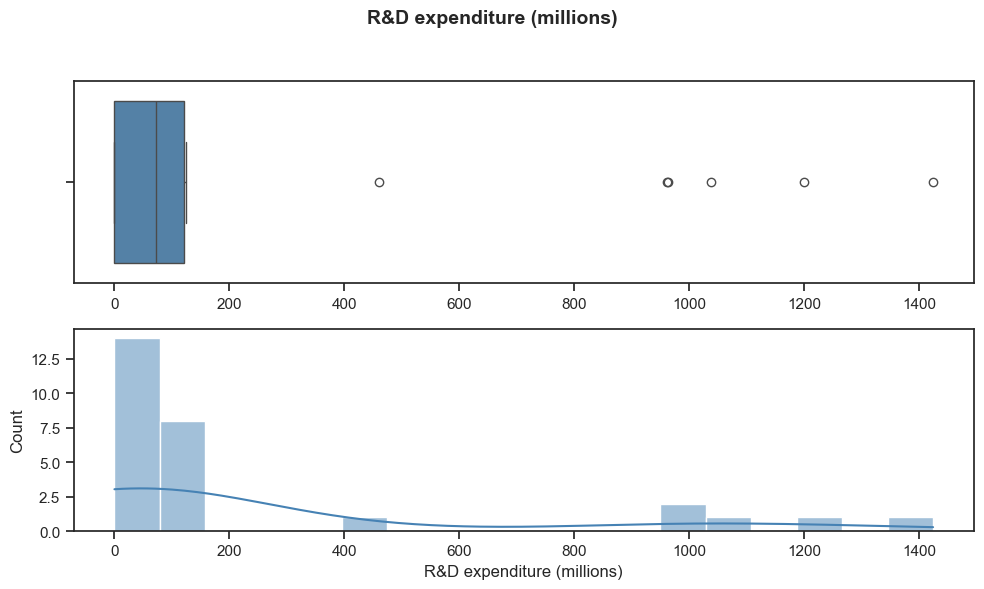

In [16]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("R&D expenditure (millions)",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['R&D expenditure (millions)'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['R&D expenditure (millions)'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("R&D expenditure (millions)")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

## **2.5 New product sales**

In [17]:
df_analysis['New products sales (millions)'].describe()

count       28.000000
mean      4657.911286
std       7936.571830
min          0.000000
25%         94.125000
50%       2118.000000
75%       4598.437500
max      36200.766000
Name: New products sales (millions), dtype: float64

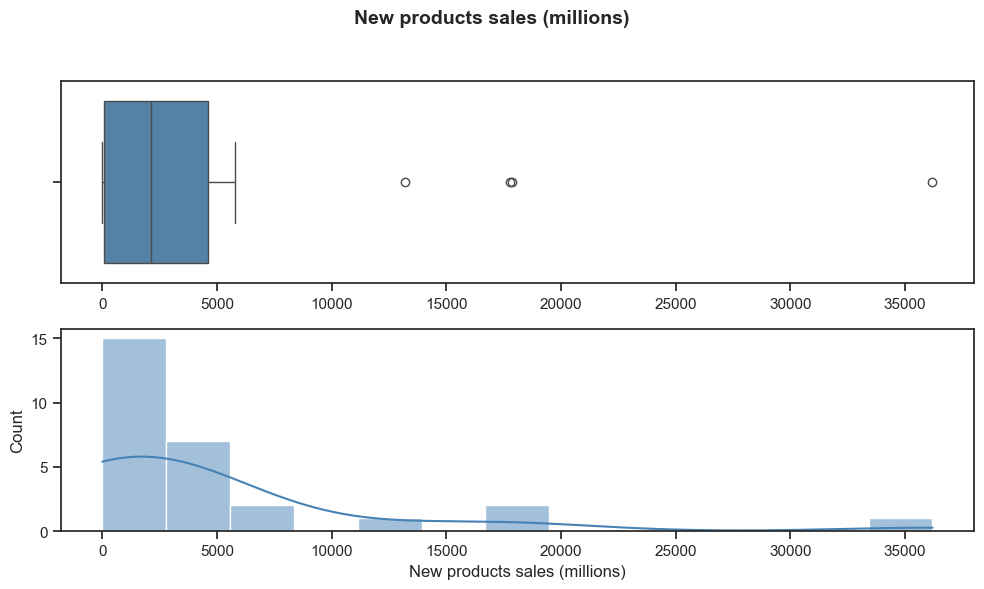

In [18]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("New products sales (millions)",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['New products sales (millions)'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['New products sales (millions)'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("New products sales (millions)")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

## **2.6 Number of patents innovations**

In [19]:
df_analysis['Number of patents innovations'].describe()

count    28.000000
mean      3.285714
std       2.706058
min       0.000000
25%       2.000000
50%       3.000000
75%       4.000000
max      12.000000
Name: Number of patents innovations, dtype: float64

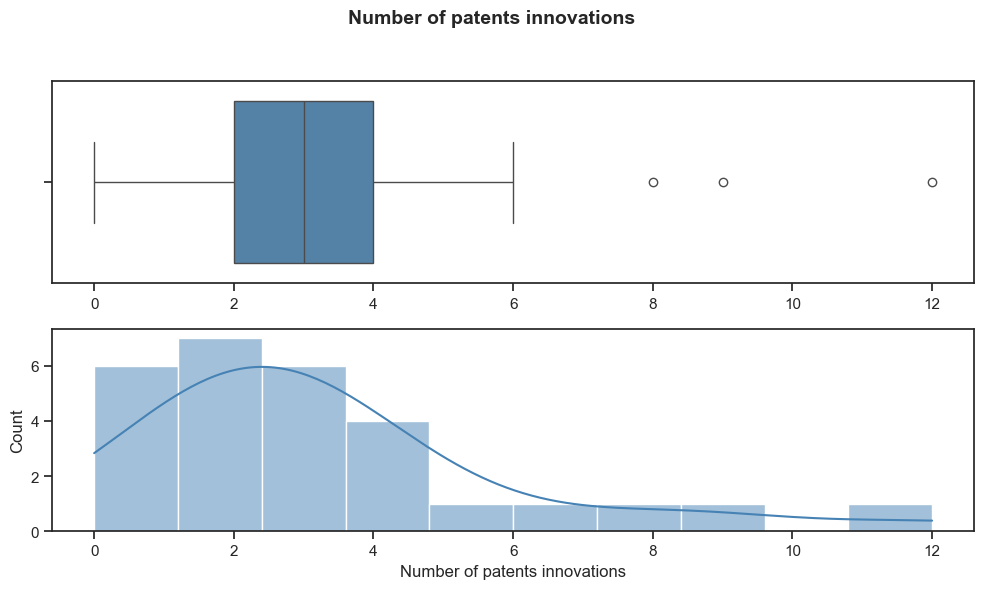

In [20]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("Number of patents innovations",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['Number of patents innovations'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['Number of patents innovations'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("Number of patents innovations")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

## **2.7 Last year sales (millions)**

In [21]:
df_analysis['Last year sales (millions)'].describe()

count        28.000000
mean      29441.167953
std       34884.050470
min         120.000000
25%        4567.500000
50%       14770.000000
75%       40937.500000
max      110000.000000
Name: Last year sales (millions), dtype: float64

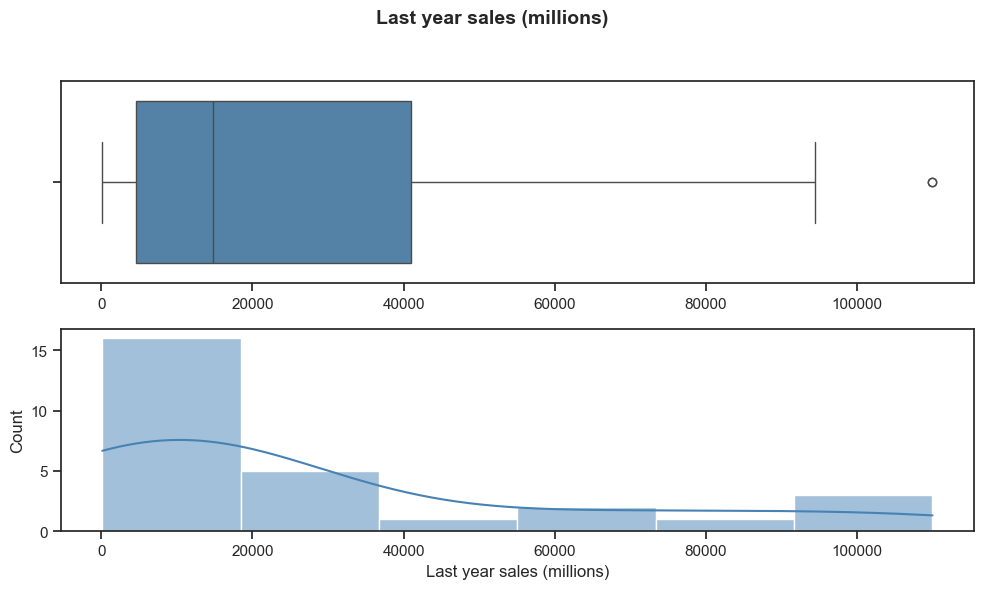

In [22]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("Last year sales (millions)",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['Last year sales (millions)'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['Last year sales (millions)'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("Last year sales (millions)")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

## **2.8 Company size**

In [23]:
df_analysis['Company size'].describe()

count         28
unique         4
top       Medium
freq          15
Name: Company size, dtype: object

In [24]:
tabla_freq=(pd.crosstab(index=df_analysis["Company size"],columns="count")).reset_index()
tabla_freq['Freq. Rel.']=tabla_freq['count']/sum(tabla_freq['count'])
tabla_freq.rename(columns={'count':'Freq. Abs.'},inplace=True)
tabla_freq=tabla_freq.sort_values(by='Freq. Abs.',ascending=False).reset_index(drop=True)
tabla_freq

col_0,Company size,Freq. Abs.,Freq. Rel.
0,Medium,15,0.535714
1,Small,5,0.178571
2,Big,4,0.142857
3,Micro,4,0.142857


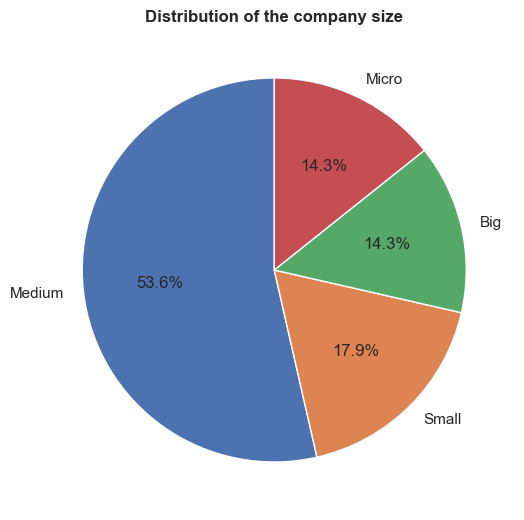

In [25]:
fig_pie = plt.figure() 
ax = fig_pie.add_axes([0, 0, 1, 1])

plt.pie(tabla_freq["Freq. Rel."],
        labels=tabla_freq["Company size"],
        autopct='%1.1f%%',
        startangle=90)

plt.title("Distribution of the company size", fontweight='bold')
plt.show()

## **2.9 Annual growth**

In [26]:
df_analysis["Annual growth"].describe()

count    28.000000
mean      0.125000
std       0.097696
min      -0.050000
25%       0.050000
50%       0.120000
75%       0.200000
max       0.400000
Name: Annual growth, dtype: float64

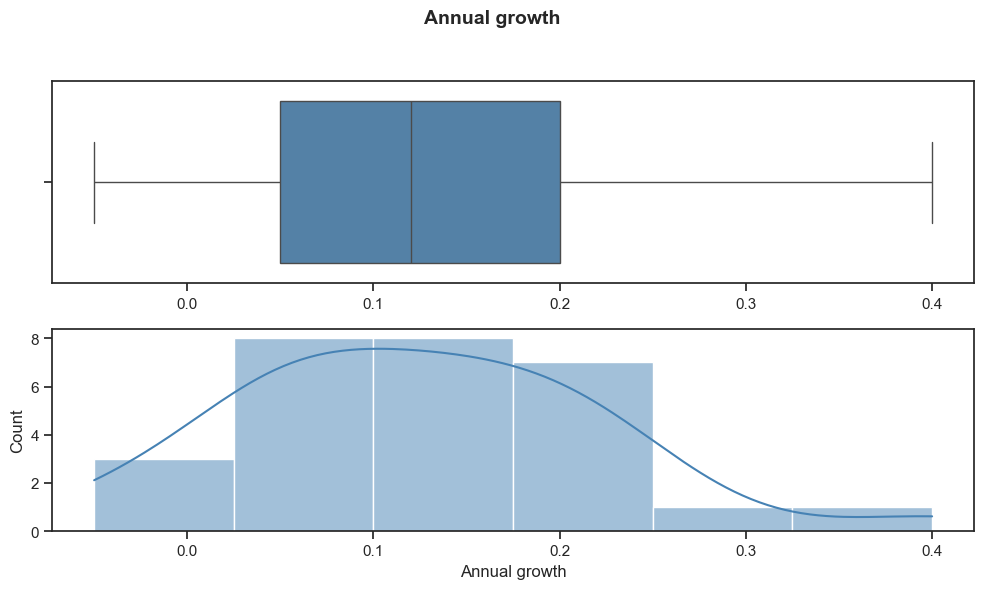

In [27]:
# Create figure with two subplots (one for boxplot and one for histogram)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))
fig.suptitle("Annual growth",
             fontsize=14, fontweight='bold')

# Boxplot
sns.boxplot(x=df_analysis['Annual growth'], color="steelblue", ax=axs[0])
axs[0].set_xlabel("")
# axs[0].set_title("Boxplot")

# Histogram with KDE
sns.histplot(df_analysis['Annual growth'], kde=True, color="steelblue", ax=axs[1])
axs[1].set_xlabel("Annual growth")
# axs[1].set_title("Histogram with KDE")

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for the main title
plt.show()

# **Sección 2 - Aplicación de modelo GRM y análisis bivariados**

## **2.1 Cargue de datos y ajuste de datasets**

In [28]:
# Cargue de datos de resultados del modelo GRM
df_grm=pd.read_excel("indices_grm_dimensiones_estandarizados.xlsx")

# Traer al dataset de resultados del modelo GRM las variables de  caracterización de las empresas
df_analysis_multivariate = df_grm.merge(
    df[["Company",'CODE',
       'Industry', '1 industry/sector:', '2 company size',
       '3 Age of the company:', 'Age of the company (segment)',
       '4 Geographic reach location:',
       '5 R&D Expenditure (Research and Development):',
       '6 new products sales:', '7 Number of patents/innovations:',
       '8 Annual growth:', '9 Last Year Sales']],
    on='CODE',
    how='left'
)

In [29]:
# Renombrar columnas para facilitar análisis
df_analysis_multivariate.rename(columns={
    '2 company size': 'Company size',
    '9 Last Year Sales': 'Last year sales',
    '3 Age of the company:': 'Age of company',
    '4 Geographic reach location:': 'Geographic reach location',
    '5 R&D Expenditure (Research and Development):': 'R&D expenditure',
    '6 new products sales:': 'New products sales',
    '7 Number of patents/innovations:': 'Number of patents innovations',
    '8 Annual growth:': 'Annual growth',
    "1 industry/sector:": "Industry/Sector"
}, inplace=True)

# Dividir la columna de industria y sector
df_analysis_multivariate[['Industry', 'Sector']] = df_analysis_multivariate['Industry/Sector'].str.split(', ', n=1, expand=True)

# Limpiar y convertir 'New products sales'
df_analysis_multivariate['New products sales'] = df_analysis_multivariate['New products sales'].astype(str)
df_analysis_multivariate['New products sales'] = df_analysis_multivariate['New products sales'].str.replace(r'[\$,]', '', regex=True)
df_analysis_multivariate['New products sales'] = df_analysis_multivariate['New products sales'].str.replace('.', '', regex=False)
df_analysis_multivariate['New products sales'] = df_analysis_multivariate['New products sales'].astype(float)

# Cambiar a inglés los valores de las columnas "Industry" y "Sector"
# Diccionario de traducción
industry_translation = {
    "Manufactura": "Manufacturing",
    "Servicios": "Services",
    "Comercio": "Commerce"
}

sector_translation = {
    "Moda": "Fashion",
    "Construcción": "Construction",
    "Comidas y bebidas": "Food and Beverages",
    "Educación": "Education",
    "Automotor": "Automotive",
    "Belleza y cuidado personal": "Beauty and Personal Care",
    "Deportes": "Sports",
    "Empaques": "Packaging",
    "Energía": "Energy",
    "Ferroelectrico": "Ferroelectric",
    "Mejora de procesos": "Process Improvement",
    "Papelería": "Stationery",
    "Tecnología": "Technology",
    "Textiles": "Textiles",
    "Transporte y logística": "Transport and Logistics"
}

# Aplicar la traducción a Industry
df_analysis_multivariate['Industry'] = df_analysis_multivariate['Industry'].replace(industry_translation)

# Limpieza previa opcional: quitar espacios extra si hay
df_analysis_multivariate['Sector'] = df_analysis_multivariate['Sector'].str.strip()
# Unificar manualmente los duplicados (si hay diferencias de acento, mayúsculas, etc.)
df_analysis_multivariate['Sector'] = df_analysis_multivariate['Sector'].replace("Tecnología", "Tecnología")
# Aplicar traducción a sector
df_analysis_multivariate['Sector'] = df_analysis_multivariate['Sector'].replace(sector_translation)

# Cambiar a millones algunas variables
df_analysis_multivariate['R&D expenditure (millions)']=df_analysis_multivariate['R&D expenditure']/1_000_000
df_analysis_multivariate['New products sales (millions)']=df_analysis_multivariate['New products sales']/1_000_000
df_analysis_multivariate['Last year sales (millions)']=df_analysis_multivariate['Last year sales']/1_000_000

# Hacer transformación a porcentaje de variable "Annual growth"
df_analysis_multivariate['Annual growth'] = df_analysis_multivariate['Annual growth'].astype(float)
df_analysis_multivariate['Annual growth (%)'] = (df_analysis_multivariate['Annual growth'] * 100).round(1).astype(str) + '%'

# Vista previa
df_analysis_multivariate.head(5)

,CODE,Indice_Sensing,Indice_Seizing,Indice_Transformation,Indice_Sensing_Z,Indice_Seizing_Z,Indice_Transformation_Z,Company,Industry,Industry/Sector,Company size,Age of company,Age of the company (segment),Geographic reach location,R&D expenditure,New products sales,Number of patents innovations,Annual growth,Last year sales,Sector,R&D expenditure (millions),New products sales (millions),Last year sales (millions),Annual growth (%)
0,C01-LT,1.584394,1.302203,1.820393,1.584908,1.307669,1.822736,C01,Manufacturing,"Manufactura, Moda",Big,29,25+ years,Regional,2.000000e-02,1.785000e+10,12,0.18,85000000000,Fashion,2.000000e-08,17850.0,85000.0,18.0%
1,C01-TM,1.613900,1.308076,1.837790,1.614417,1.313544,1.840152,C01,Manufacturing,"Manufactura, Moda",Big,29,25+ years,Regional,2.000000e-02,1.785000e+10,12,0.18,85000000000,Fashion,2.000000e-08,17850.0,85000.0,18.0%
2,C02-LT,0.475348,0.439359,0.792505,0.475718,0.444613,0.793801,C02,Services,"Servicios, Comidas y bebidas",Big,6,5-8 years,National,1.037000e+09,2.835000e+09,8,0.24,94500000000,Food and Beverages,1.037000e+03,2835.0,94500.0,24.0%
3,C02-TM,0.515720,0.432376,0.798164,0.516096,0.437629,0.799466,C02,Services,"Servicios, Comidas y bebidas",Big,6,5-8 years,National,1.037000e+09,2.835000e+09,8,0.24,94500000000,Food and Beverages,1.037000e+03,2835.0,94500.0,24.0%
4,C03-LT,0.421892,0.641390,0.577742,0.422256,0.646694,0.578820,C03,Manufacturing,"Manufactura, Moda",Big,8,5-8 years,Local,0.000000e+00,1.320000e+10,4,0.10,110000000000,Fashion,0.000000e+00,13200.0,110000.0,10.0%


In [30]:
# Promediar los valores de variables latentes por cada compañía
# Agrupar por empresa y calcular promedios de los índices latentes y sus z-scores
df_analysis_multivariate_final = df_analysis_multivariate.groupby('Company').agg({
    'Indice_Sensing': 'mean',
    'Indice_Seizing': 'mean',
    'Indice_Transformation': 'mean',
    'Indice_Sensing_Z': 'mean',
    'Indice_Seizing_Z': 'mean',
    'Indice_Transformation_Z': 'mean',
    'Company size': 'first',
    'Industry': 'first',
    'Sector': 'first',
    "Last year sales": 'first',
    "Age of company":"first",
    "Geographic reach location": 'first',
    "R&D expenditure": 'first',
    "New products sales": 'first',
    "Number of patents innovations": 'first',
    "Annual growth": 'first'
}).reset_index()

In [31]:
df_analysis_multivariate_final.rename(columns={
    'Indice_Sensing': 'Latent_sensing',
    'Indice_Seizing': 'Latent_seizing',
    'Indice_Transformation': 'Latent_transformation',
    'Indice_Sensing_Z': 'Latent_sensing_Z',
    'Indice_Seizing_Z': 'Latent_seizing_Z',
    'Indice_Transformation_Z': 'Latent_transformation_Z',
}, inplace=True)

In [32]:
df_analysis_multivariate_final

,Company,Latent_sensing,Latent_seizing,Latent_transformation,Latent_sensing_Z,Latent_seizing_Z,Latent_transformation_Z,Company size,Industry,Sector,Last year sales,Age of company,Geographic reach location,R&D expenditure,New products sales,Number of patents innovations,Annual growth
0,C01,1.599147,1.305140,1.829091,1.599663,1.310607,1.831444,Big,Manufacturing,Fashion,85000000000,29,Regional,2.000000e-02,1.785000e+10,12,0.18
1,C02,0.495534,0.435867,0.795335,0.495907,0.441121,0.796633,Big,Services,Food and Beverages,94500000000,6,National,1.037000e+09,2.835000e+09,8,0.24
2,C03,1.566232,1.703583,1.637924,1.566743,1.709148,1.640082,Big,Manufacturing,Fashion,110000000000,8,Local,0.000000e+00,1.320000e+10,4,0.10
3,C04,-0.467213,-0.401244,-0.331791,-0.466963,-0.396196,-0.331641,Medium,Services,Transport and Logistics,13450000000,23,International,1.200000e+09,4.800000e+09,6,0.15
4,C05,0.318504,0.533603,0.398109,0.318855,0.538881,0.399003,Medium,Services,Technology,19250000000,25,National,9.625000e+08,3.850000e+09,4,0.08
5,C06,-1.502069,-1.351313,-1.699216,-1.501954,-1.346499,-1.700460,Medium,Manufacturing,Construction,71200000000,30,National,1.424000e+09,1.780000e+10,4,0.26
6,C07,0.241241,0.006293,-0.390087,0.241581,0.011441,-0.389997,Medium,Manufacturing,Construction,64000000000,40,National,1.000000e+07,3.620077e+10,3,0.20
7,C08,-0.200324,-0.130438,0.592535,-0.200041,-0.125323,0.593628,Small,Manufacturing,Fashion,3270000000,12,National,9.810000e+07,3.270000e+08,3,0.12
8,C09,2.190476,2.629447,2.181530,2.191067,2.635239,2.184242,Big,Commerce,Ferroelectric,110000000000,24,International,1.200000e+08,2.600000e+08,2,0.14
9,C10,0.501075,-0.009984,0.578918,0.501449,-0.004840,0.579997,Medium,Manufacturing,Fashion,14760000000,21,Local,1.000000e+08,1.476000e+09,3,-0.03


## **2.2 Análisis bivariados - Índice Sensing**

### **2.2.1 Tamaño de la empresa**

#### **Comprobación de normalidad de los datos**

In [34]:
# Aplicar Shapiro-Wilk a cada grupo
for group in df_analysis_multivariate_final['Company size'].unique():
    datos_grupo = df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == group]['Latent_sensing']
    stat, p = shapiro(datos_grupo)
    print(f"\nGrupo: {group}")
    print(f"Estadístico Shapiro-Wilk: {stat:.4f}, p-valor: {p:.4f}")
    if p < 0.05:
        print("→ No es normal (rechaza H0)")
    else:
        print("→ Normal (no rechaza H0)")


Grupo: Big
Estadístico Shapiro-Wilk: 0.9166, p-valor: 0.5178
→ Normal (no rechaza H0)

Grupo: Medium
Estadístico Shapiro-Wilk: 0.9561, p-valor: 0.6249
→ Normal (no rechaza H0)

Grupo: Small
Estadístico Shapiro-Wilk: 0.9295, p-valor: 0.5929
→ Normal (no rechaza H0)

Grupo: Micro
Estadístico Shapiro-Wilk: 0.9628, p-valor: 0.7965
→ Normal (no rechaza H0)


#### **Comprobación de homogeneidad de varianzas**

In [35]:
# Agrupar los datos por grupo
grupos = df_analysis_multivariate_final['Company size'].unique()
datos_por_grupo = [df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == g]['Latent_sensing'] for g in grupos]

# Aplicar prueba de Levene
stat, p = levene(*datos_por_grupo)
print(f"Estadístico Levene: {stat:.4f}, p-valor: {p:.4f}")

if p < 0.05:
    print("→ Varianzas diferentes (rechaza H0)")
else:
    print("→ Varianzas iguales (no rechaza H0)")

Estadístico Levene: 0.9367, p-valor: 0.4383
→ Varianzas iguales (no rechaza H0)


#### **Aplicación de pruebas estadísticas para revisión de diferencias entre medianas**


Classical ANOVA results:
F-statistic: 12.5298
P-value: 0.0000

ANOVA is significant (p < 0.05). Applying Tukey HSD test...


C:\Users\andre\AppData\Local\Temp\ipykernel_21236\3066959377.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Company size', y='Latent_sensing', data=df_analysis_multivariate_final,


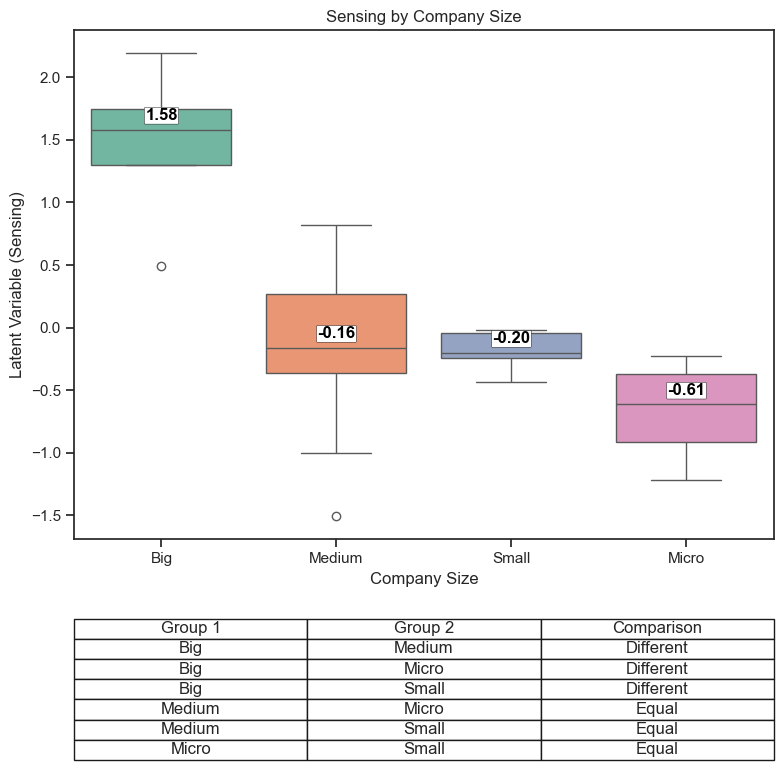

In [36]:
# 1. Classical ANOVA
groups = df_analysis_multivariate_final.groupby('Company size')['Latent_sensing'].apply(list)
f_stat, p_value = f_oneway(*groups)

print("\nClassical ANOVA results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 2. Check if significant
if p_value < 0.05:
    print("\nANOVA is significant (p < 0.05). Applying Tukey HSD test...")

    # 3. Tukey HSD post-hoc test
    tukey = pairwise_tukeyhsd(endog=df_analysis_multivariate_final['Latent_sensing'],
                              groups=df_analysis_multivariate_final['Company size'],
                              alpha=0.05)
    tukey_summary = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_summary['Interpretation'] = tukey_summary['p-adj'].apply(lambda x: 'Different' if x < 0.05 else 'Equal')

    # 4. Compute medians by group and sort
    medians = df_analysis_multivariate_final.groupby('Company size')['Latent_sensing'].median().reset_index()
    category_order = medians.sort_values('Latent_sensing', ascending=False)['Company size'].tolist()

    # 5. Create figure (boxplot + table)
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

    sns.boxplot(x='Company size', y='Latent_sensing', data=df_analysis_multivariate_final,
                ax=ax[0], palette="Set2", order=category_order)
    ax[0].set_title("Sensing by Company Size")
    ax[0].set_xlabel("Company Size")
    ax[0].set_ylabel("Latent Variable (Sensing)")

    # Annotate medians
    for i, row in medians.iterrows():
        idx = category_order.index(row['Company size'])
        offset = 0.05
        ax[0].text(idx, row['Latent_sensing'] + offset, 
                   f"{row['Latent_sensing']:.2f}", 
                   ha='center', va='bottom', fontweight='bold', color='black',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.05', linewidth=0.3))

    # 6. Add table below the plot
    table = tukey_summary[['group1', 'group2', 'Interpretation']]
    ax[1].axis('off')
    table_text = table.values.tolist()
    column_labels = ['Group 1', 'Group 2', 'Comparison']
    ax[1].table(cellText=table_text, colLabels=column_labels, loc='center', cellLoc='center')

    plt.tight_layout()
    plt.show()

else:
    print("\nANOVA is not significant (p ≥ 0.05). Tukey HSD test and plot will not be generated.")


### **2.2.2 Ventas de la empresa**

In [ ]:
df_analysis_multivariate_final["Last year sales"]=df_analysis_multivariate_final["Last year sales"]/1_000_000

Pearson correlation coefficient: r = 0.5802
p-value: 0.0012
There is significant evidence of a linear correlation between 'Latent_sensing' and 'Last year sales'.


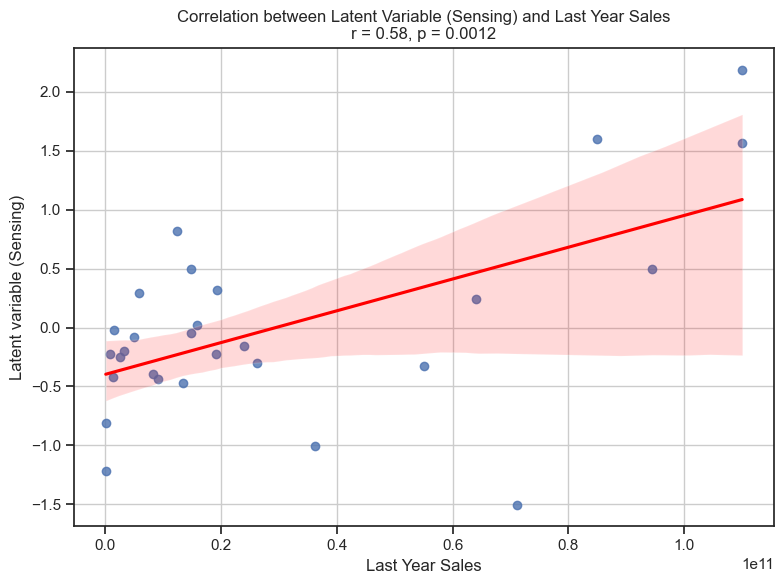

In [37]:
# Pearson correlation coefficient and p-value calculation
r, p_value = pearsonr(df_analysis_multivariate_final['Latent_sensing'], df_analysis_multivariate_final['Last year sales'])

# Results
print(f"Pearson correlation coefficient: r = {r:.4f}")
print(f"p-value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("There is significant evidence of a linear correlation between 'Latent_sensing' and 'Last year sales'.")
else:
    print("No significant evidence of a linear correlation was found between 'Latent_sensing' and 'Last year sales'.")

# Visualization
plt.figure(figsize=(8, 6))
sns.regplot(data=df_analysis_multivariate_final, x='Last year sales', y='Latent_sensing', ci=95, line_kws={'color': 'red'})
plt.title(f"Correlation between Latent Variable (Sensing) and Last Year Sales\nr = {r:.2f}, p = {p_value:.4f}")
plt.xlabel("Last Year Sales")
plt.ylabel("Latent variable (Sensing)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [39]:
df_promedio_empresa_corr=df_analysis_multivariate_final.copy()

# Cammbio de nombre de Indice_Sensing
df_promedio_empresa_corr.rename(columns={'Latent_sensing': 'Latent variable (Sensing)'}, inplace=True)

# Elegir las columnas que se desean analizar
df_promedio_empresa_corr = df_promedio_empresa_corr[["Latent variable (Sensing)","Company size","Last year sales"]]

categorical_features=identify_nominal_columns(df_promedio_empresa_corr)
continuous_features=identify_numeric_columns(df_promedio_empresa_corr)

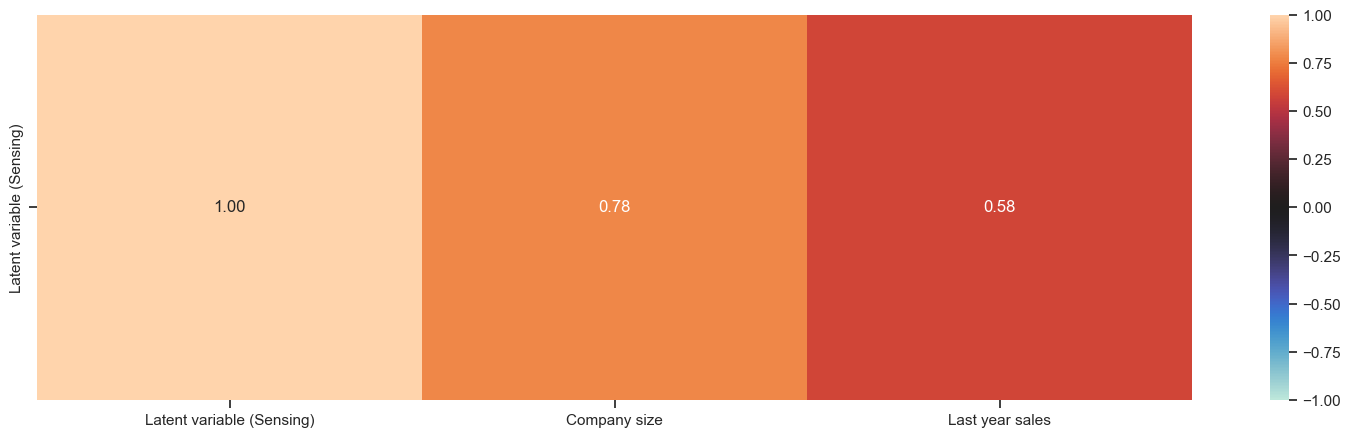

In [40]:
from dython.nominal import associations
target_correlation= associations(df_promedio_empresa_corr, display_rows=["Latent variable (Sensing)"], filename= 'target_correlation.png', figsize=(20,5))

In [41]:
df_promedio_empresa_reg_lineal = df_analysis_multivariate_final[["Latent_sensing","Last year sales"]]

x=df_promedio_empresa_reg_lineal.drop(["Last year sales"], axis=1)
y=df_promedio_empresa_reg_lineal["Last year sales"]
X = sm.add_constant(x) 
model = sm.OLS(y,X)
result=model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Last year sales   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     13.20
Date:              sáb., 14 jun. 2025   Prob (F-statistic):            0.00121
Time:                        01:22:30   Log-Likelihood:                -713.18
No. Observations:                  28   AIC:                             1430.
Df Residuals:                      26   BIC:                             1433.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.945e+10   5.47e+09      5.382      0.000    1.82e+10    4.07e+10
Latent_sensing  2.494e+10   6.87e+09      3.633      0.001    1.08e+10    3.91e+10
==============================================================================
Omnibus:                        6.971   Durbin-Watson:                   1.727
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                5.490
Skew:                           1.060   Prob(JB):                       0.0643
Kurtosis:                       3.463   Cond. No.                         1.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**I) Linealidad**

In [42]:
# Extrae las columnas Y y X del DataFrame
Y = df_analysis_multivariate_final['Last year sales']
X = df_analysis_multivariate_final['Latent_sensing']

In [43]:
# Calcula el coeficiente de correlación de Pearson y el valor p
correlation_coefficient, p_value = stats.pearsonr(Y, X)

# nivel de significancia (alpha)
alpha = 0.05

# Comparar el valor p con el nivel de significancia
if p_value < alpha:
    print("Hay evidencia de una relación lineal significativa (p < alpha)")
else:
    print("No hay evidencia de una relación lineal significativa (p >= alpha)")

print(f"Coeficiente de correlación de Pearson: {correlation_coefficient}")

Hay evidencia de una relación lineal significativa (p < alpha)
Coeficiente de correlación de Pearson: 0.5802331448482475


Se evidencia una relación lineal positiva y significativa. Aunque el ajuiste del modelo es bajo.

**II) Independencia de errores** 

Text(0, 0.5, 'Error (i)')

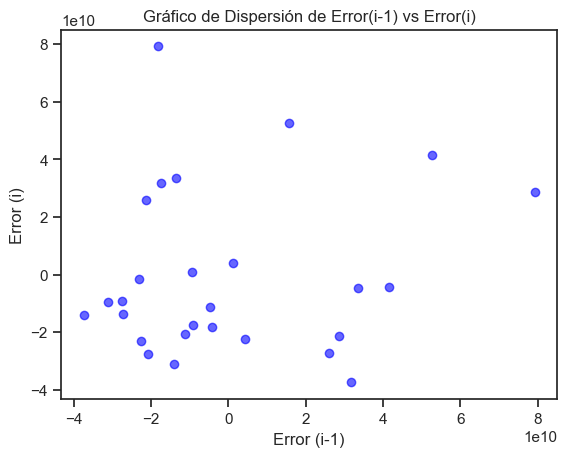

In [44]:
errores = result.resid
errores_i_1 = errores[:-1]
errores_i = errores[1:]

plt.scatter(errores_i_1, errores_i,c='blue', marker='o',alpha=0.6)
plt.title('Gráfico de Dispersión de Error(i-1) vs Error(i)')
plt.xlabel('Error (i-1)')
plt.ylabel('Error (i)')

En el gráfico anterior se evidencia que la dispersión sigue un patrón de esfericidad, por lo que se puede anticipar la no existencia de autocorrelación en los errores. Sin embargo, se procede a ejecutar una prueba estadística para confirmar lo anterior.

Según lo reportado en la tabla anterior, el estadístico de la prueba de Durbin Watson tiene un valor de 1.727. Las pruebas de hipótesis de esta prueba son las siguientes:

- **H0: cor(e_i,e_{i-1}==0** -> esto es NO hay autocorrelación entre los errores
- **H1: cor(e_i,e_{i-1}!=0** -> esto es SÍ hay autocorrelación entre los erorres

En este caso el estadístico DW está en el intervalo 1.5 y 2.5, por lo que no se debe rechazar la hipótesis nula de no autocorrelación, lo que permite **evidenciar la no autocorrelación entre los errores**.

**III) Homocedasticidad**

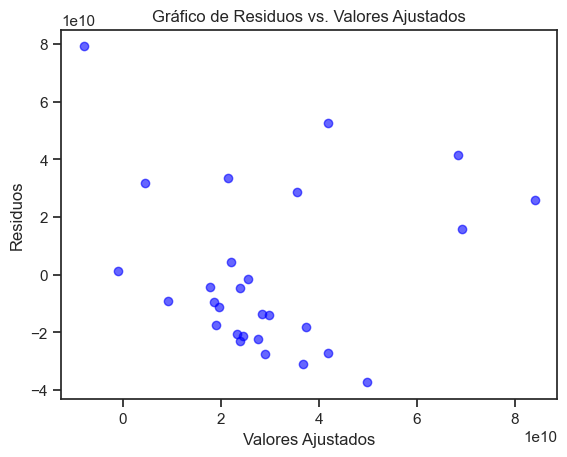

In [45]:
# Calcula los valores ajustados del modelo
valores_ajustados = result.fittedvalues

# Gráfico de dispersión de residuos vs valores ajustados
plt.scatter(valores_ajustados, errores, c='blue', marker='o', alpha=0.6)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Valores Ajustados')
plt.show()

In [46]:
# Suponiendo que 'modelo' es tu modelo de regresión ajustado
prueba_homocedasticidad = het_breuschpagan(errores, result.model.exog)

# La prueba devuelve varios valores, puedes ver el p-valor así:
p_valor = prueba_homocedasticidad[3]

print(f"P-valor asociado a la prueba Breusch Pagan: {p_valor}")

P-valor asociado a la prueba Breusch Pagan: 0.52326041031194


Las hipótesis asociadas a esta prueba son las siguientes:

- **HO: e_i son homocedásticos** (homogeneidad de la varianza)
- **H1: e_i no son homocedásticos** (heterogeneidad de la varianza)
    
En este caso, el p-valor asociado a la prueba de Breusch-Pagan es mayor a un nivel de significancia de 0.05, lo que lleva a aceptar la hipótesis nula de homocedasticidad. En este sentido, se concluye que **el modelo cumple con el supuesto de homocedasticidad en la varianza de los errores**.

**IV) Normalidad de los residuos**

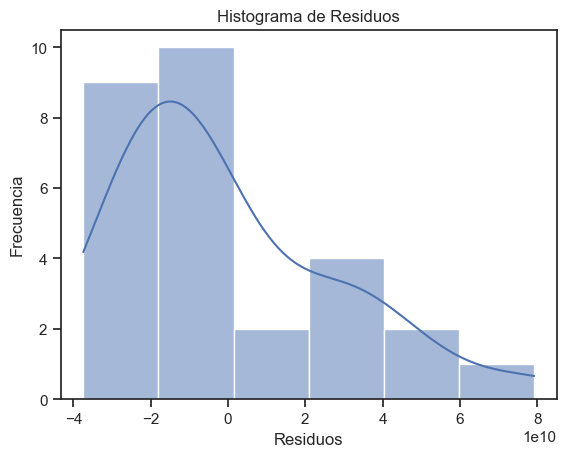

In [47]:
sns.histplot(errores, kde=True)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.show()

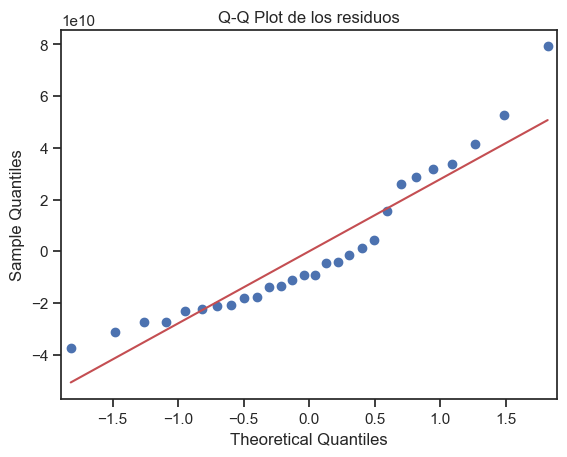

In [48]:
# Crear el Q-Q plot
sm.qqplot(errores, line='s')  # 's' = línea de referencia con pendiente 1 (esperada si es normal)
plt.title("Q-Q Plot de los residuos")
plt.show()

In [49]:
# Aplicar la prueba de Shapiro-Wilk
stat, p = shapiro(errores)

# Mostrar el resultado
print("📊 Prueba de normalidad Shapiro-Wilk")
print(f"Estadístico W: {stat:.4f}")
print(f"Valor p: {p:.4f}")

# Interpretación
if p < 0.05:
    print("❌ Rechazamos H₀: los datos no siguen una distribución normal.")
else:
    print("✅ No se rechaza H₀: no hay evidencia de no normalidad.")

📊 Prueba de normalidad Shapiro-Wilk
Estadístico W: 0.8981
Valor p: 0.0103
❌ Rechazamos H₀: los datos no siguen una distribución normal.


El modelo OLS clásico cumple con todos los supuestos, menos con el de normalidad. En este caso, es necesario aplicar una transformación a la variable dependiente para que los residuos se ajusten a una distribución normal. Una opción es aplicar una transformación logarítmica a la variable dependiente, que en este caso es "Last year sales". Se procede con esta transformación.

In [50]:
# Si hay valores positivos, podemos aplicar log
y_log = np.log(df_analysis_multivariate_final['Last year sales'])

# Variable independiente
X = df_analysis_multivariate_final['Latent_sensing']
X_const = sm.add_constant(X)

# Ajustar modelo con Y transformada
modelo_log = sm.OLS(y_log, X_const).fit()

# Residuales del modelo logarítmico
residuos_log = modelo_log.resid

# Resumen del modelo
modelo_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Last year sales   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     8.204
Date:              sáb., 14 jun. 2025   Prob (F-statistic):            0.00816
Time:                        01:23:31   Log-Likelihood:                -52.033
No. Observations:                  28   AIC:                             108.1
Df Residuals:                      26   BIC:                             110.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             23.1064      0.304     75.927      0.000      22.481      23.732
Latent_sensing     1.0938      0.382      2.864      0.008       0.309       1.879
==============================================================================
Omnibus:                        0.569   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.753   Jarque-Bera (JB):                0.168
Skew:                          -0.189   Prob(JB):                        0.919
Kurtosis:                       3.041   Cond. No.                         1.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**I) Linealidad**

In [51]:
# Calcula el coeficiente de correlación de Pearson y el valor p
correlation_coefficient, p_value = stats.pearsonr(y_log, X)

# nivel de significancia (alpha)
alpha = 0.05

# Comparar el valor p con el nivel de significancia
if p_value < alpha:
    print("Hay evidencia de una relación lineal significativa (p < alpha)")
else:
    print("No hay evidencia de una relación lineal significativa (p >= alpha)")

print(f"Coeficiente de correlación de Pearson: {correlation_coefficient}")

Hay evidencia de una relación lineal significativa (p < alpha)
Coeficiente de correlación de Pearson: 0.48974375997374225


Se evidencia una relación lineal positiva y significativa. Aunque el ajuiste del modelo es bajo.

**II) Independencia de errores** 

Text(0, 0.5, 'Error (i)')

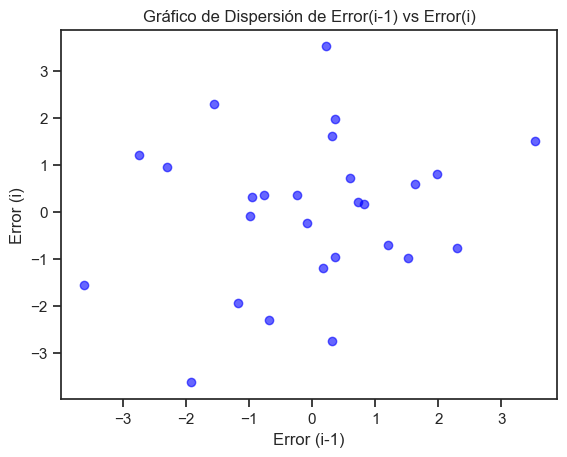

In [52]:
errores = modelo_log.resid
errores_i_1 = errores[:-1]
errores_i = errores[1:]

plt.scatter(errores_i_1, errores_i,c='blue', marker='o',alpha=0.6)
plt.title('Gráfico de Dispersión de Error(i-1) vs Error(i)')
plt.xlabel('Error (i-1)')
plt.ylabel('Error (i)')

En el gráfico anterior se evidencia que la dispersión sigue un patrón de esfericidad, por lo que se puede anticipar la no existencia de autocorrelación en los errores. Sin embargo, se procede a ejecutar una prueba estadística para confirmar lo anterior.

Según lo reportado en la tabla anterior, el estadístico de la prueba de Durbin Watson tiene un valor de 1.630. Las pruebas de hipótesis de esta prueba son las siguientes:

- **H0: cor(e_i,e_{i-1}==0** -> esto es NO hay autocorrelación entre los errores
- **H1: cor(e_i,e_{i-1}!=0** -> esto es SÍ hay autocorrelación entre los erorres

En este caso el estadístico DW está en el intervalo 1.5 y 2.5, por lo que no se debe rechazar la hipótesis nula de no autocorrelación, lo que permite **evidenciar la no autocorrelación entre los errores**.

**III) Homocedasticidad**

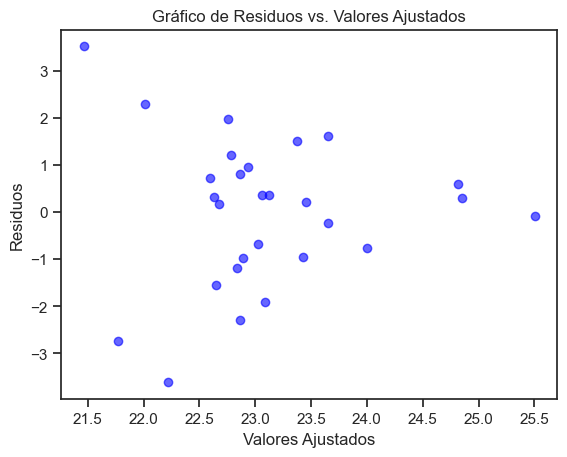

In [53]:
# Calcula los valores ajustados del modelo
valores_ajustados = modelo_log.fittedvalues

# Gráfico de dispersión de residuos vs valores ajustados
plt.scatter(valores_ajustados, errores, c='blue', marker='o', alpha=0.6)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Valores Ajustados')
plt.show()

In [54]:
# Suponiendo que 'modelo' es tu modelo de regresión ajustado
prueba_homocedasticidad = het_breuschpagan(errores, modelo_log.model.exog)

# La prueba devuelve varios valores, puedes ver el p-valor así:
p_valor = prueba_homocedasticidad[3]

print(f"P-valor asociado a la prueba Breusch Pagan: {p_valor}")

P-valor asociado a la prueba Breusch Pagan: 0.0009135457562928613


Las hipótesis asociadas a esta prueba son las siguientes:

- **HO: e_i son homocedásticos** (homogeneidad de la varianza)
- **H1: e_i no son homocedásticos** (heterogeneidad de la varianza)
    
En este caso, el p-valor asociado a la prueba de Breusch-Pagan es menor a un nivel de significancia de 0.05, lo que lleva a rechazar la hipótesis nula de homocedasticidad. En este sentido, se concluye que **el modelo NO cumple con el supuesto de homocedasticidad en la varianza de los errores**.

**IV) Normalidad de los residuos**

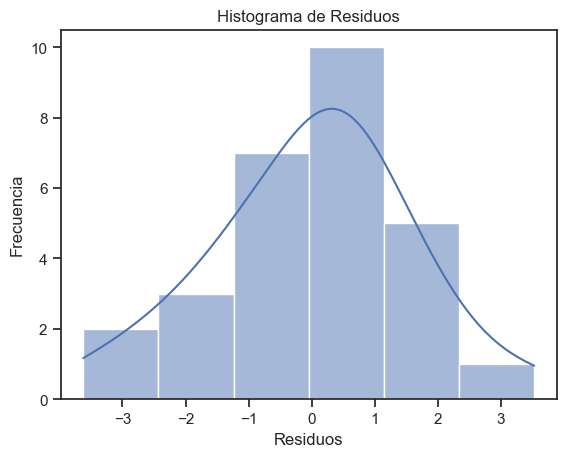

In [55]:
sns.histplot(errores, kde=True)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.show()

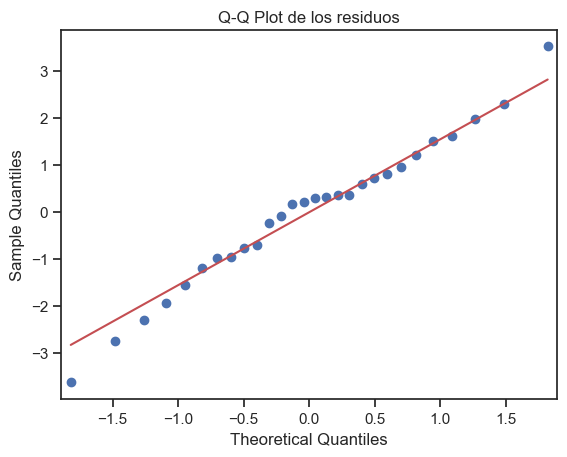

In [56]:
# Crear el Q-Q plot
sm.qqplot(errores, line='s')  # 's' = línea de referencia con pendiente 1 (esperada si es normal)
plt.title("Q-Q Plot de los residuos")
plt.show()

In [57]:
# Aplicar la prueba de Shapiro-Wilk
stat, p = shapiro(errores)

# Mostrar el resultado
print("📊 Prueba de normalidad Shapiro-Wilk")
print(f"Estadístico W: {stat:.4f}")
print(f"Valor p: {p:.4f}")

# Interpretación
if p < 0.05:
    print("❌ Rechazamos H₀: los datos no siguen una distribución normal.")
else:
    print("✅ No se rechaza H₀: no hay evidencia de no normalidad.")

📊 Prueba de normalidad Shapiro-Wilk
Estadístico W: 0.9883
Valor p: 0.9841
✅ No se rechaza H₀: no hay evidencia de no normalidad.


Este modelo con variable dependiente transformada (log) tiene un mejor ajuste que el modelo original OLS clásico, ya que los residuos parecen más homogéneos. En este caso, el modelo cumple con el supuesto de normalidad de los errores; sin embargo, no cumple el supuesto de homocedasticidad. En este caso, se correrá un modelo robusto que no asuma homocedasticidad.

In [58]:
# Transformación logarítmica de la variable dependiente
y_log = np.log(df_analysis_multivariate_final['Last year sales'])

# Variable independiente
X = df_analysis_multivariate_final['Latent_sensing']
X_const = sm.add_constant(X)

# Ajustar modelo OLS con errores estándar robustos (White)
modelo_robust_log = sm.OLS(y_log, X_const).fit(cov_type='HC1')

# Mostrar resumen del modelo
modelo_robust_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Last year sales   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     6.166
Date:              sáb., 14 jun. 2025   Prob (F-statistic):             0.0198
Time:                        01:24:03   Log-Likelihood:                -52.033
No. Observations:                  28   AIC:                             108.1
Df Residuals:                      26   BIC:                             110.7
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             23.1064      0.304     75.952      0.000      22.510      23.703
Latent_sensing     1.0938      0.440      2.483      0.013       0.230       1.957
==============================================================================
Omnibus:                        0.569   Durbin-Watson:                   1.630
Prob(Omnibus):                  0.753   Jarque-Bera (JB):                0.168
Skew:                          -0.189   Prob(JB):                        0.919
Kurtosis:                       3.041   Cond. No.                         1.25
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

**I) Linealidad**

In [59]:
# Calcula el coeficiente de correlación de Pearson y el valor p
correlation_coefficient, p_value = stats.pearsonr(y_log, X)

# nivel de significancia (alpha)
alpha = 0.05

# Comparar el valor p con el nivel de significancia
if p_value < alpha:
    print("Hay evidencia de una relación lineal significativa (p < alpha)")
else:
    print("No hay evidencia de una relación lineal significativa (p >= alpha)")

print(f"Coeficiente de correlación de Pearson: {correlation_coefficient}")

Hay evidencia de una relación lineal significativa (p < alpha)
Coeficiente de correlación de Pearson: 0.48974375997374225


Se evidencia una relación lineal positiva y significativa. Aunque el ajuiste del modelo es bajo.

**II) Independencia de errores** 

Text(0, 0.5, 'Error (i)')

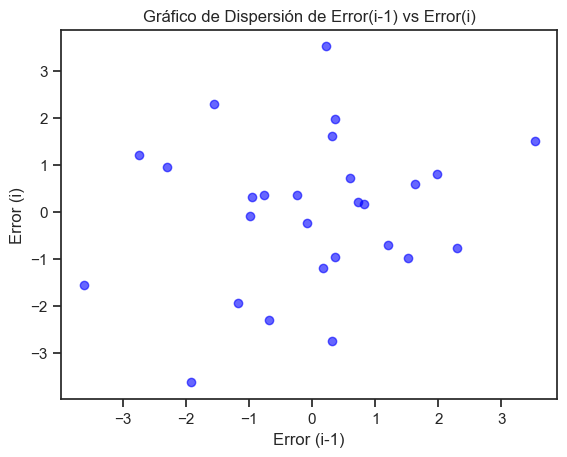

In [60]:
errores = modelo_robust_log.resid
errores_i_1 = errores[:-1]
errores_i = errores[1:]

plt.scatter(errores_i_1, errores_i,c='blue', marker='o',alpha=0.6)
plt.title('Gráfico de Dispersión de Error(i-1) vs Error(i)')
plt.xlabel('Error (i-1)')
plt.ylabel('Error (i)')

En el gráfico anterior se evidencia que la dispersión sigue un patrón de esfericidad, por lo que se puede anticipar la no existencia de autocorrelación en los errores. Sin embargo, se procede a ejecutar una prueba estadística para confirmar lo anterior.

Según lo reportado en la tabla anterior, el estadístico de la prueba de Durbin Watson tiene un valor de 1.630. Las pruebas de hipótesis de esta prueba son las siguientes:

- **H0: cor(e_i,e_{i-1}==0** -> esto es NO hay autocorrelación entre los errores
- **H1: cor(e_i,e_{i-1}!=0** -> esto es SÍ hay autocorrelación entre los erorres

En este caso el estadístico DW está en el intervalo 1.5 y 2.5, por lo que no se debe rechazar la hipótesis nula de no autocorrelación, lo que permite **evidenciar la no autocorrelación entre los errores**.

**III) Homocedasticidad**

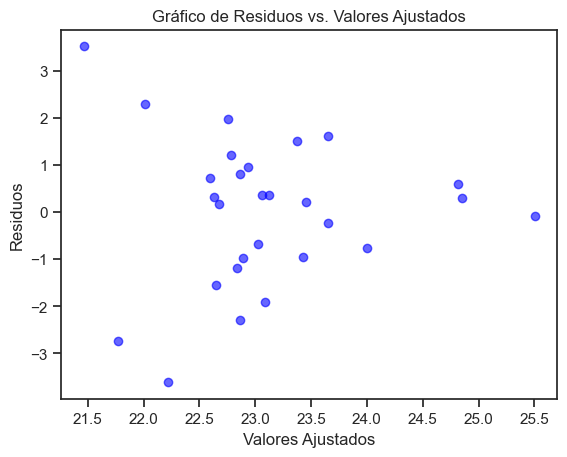

In [61]:
# Calcula los valores ajustados del modelo
valores_ajustados = modelo_robust_log.fittedvalues

# Gráfico de dispersión de residuos vs valores ajustados
plt.scatter(valores_ajustados, errores, c='blue', marker='o', alpha=0.6)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Valores Ajustados')
plt.show()

In [62]:
# Suponiendo que 'modelo' es tu modelo de regresión ajustado
prueba_homocedasticidad = het_breuschpagan(errores, modelo_robust_log.model.exog)

# La prueba devuelve varios valores, puedes ver el p-valor así:
p_valor = prueba_homocedasticidad[3]

print(f"P-valor asociado a la prueba Breusch Pagan: {p_valor}")

P-valor asociado a la prueba Breusch Pagan: 0.0009135457562928613


Las hipótesis asociadas a esta prueba son las siguientes:

- **HO: e_i son homocedásticos** (homogeneidad de la varianza)
- **H1: e_i no son homocedásticos** (heterogeneidad de la varianza)
    
En este caso, el p-valor asociado a la prueba de Breusch-Pagan es menor a un nivel de significancia de 0.05, lo que lleva a aceptar la hipótesis nula de homocedasticidad. En este sentido, se concluye que **el modelo NO cumple con el supuesto de homocedasticidad en la varianza de los errores**.

**IV) Normalidad de los residuos**

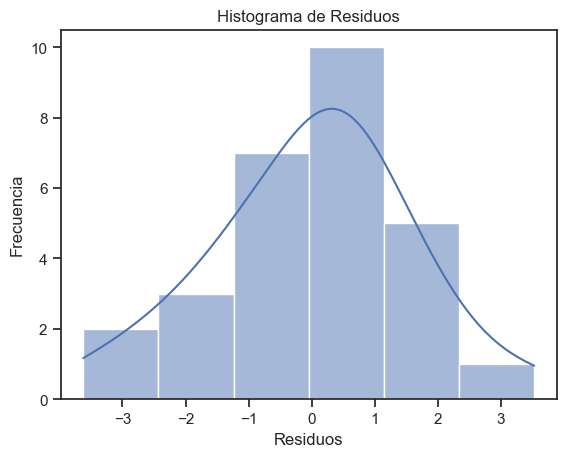

In [63]:
sns.histplot(errores, kde=True)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.show()

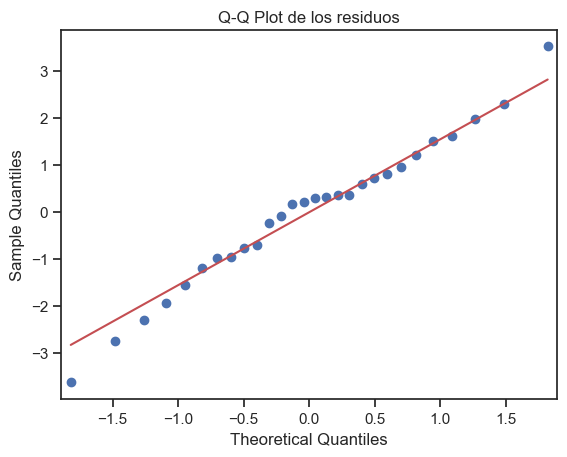

In [64]:
# Crear el Q-Q plot
sm.qqplot(errores, line='s')  # 's' = línea de referencia con pendiente 1 (esperada si es normal)
plt.title("Q-Q Plot de los residuos")
plt.show()

In [65]:
# Aplicar la prueba de Shapiro-Wilk
stat, p = shapiro(errores)

# Mostrar el resultado
print("📊 Prueba de normalidad Shapiro-Wilk")
print(f"Estadístico W: {stat:.4f}")
print(f"Valor p: {p:.4f}")

# Interpretación
if p < 0.05:
    print("❌ Rechazamos H₀: los datos no siguen una distribución normal.")
else:
    print("✅ No se rechaza H₀: no hay evidencia de no normalidad.")

📊 Prueba de normalidad Shapiro-Wilk
Estadístico W: 0.9883
Valor p: 0.9841
✅ No se rechaza H₀: no hay evidencia de no normalidad.


Este modelo no cumple homocedasticidad, sin embargo, al aplicar errores estándar robustos, se ajusta para corregir la heterocedasticidad. Esto permite que las inferencias estadísticas sean más confiables a pesar de la violación de la homocedasticidad.

### **2.2.3 Industria de la empresa**

#### **Comprobación de normalidad de los datos**

In [ ]:
# Aplicar Shapiro-Wilk a cada grupo
for group in df_analysis_multivariate_final['Industry'].unique():
    datos_grupo = df_analysis_multivariate_final[df_analysis_multivariate_final['Industry'] == group]['Indice_Sensing']
    stat, p = shapiro(datos_grupo)
    print(f"\nGrupo: {group}")
    print(f"Estadístico Shapiro-Wilk: {stat:.4f}, p-valor: {p:.4f}")
    if p < 0.05:
        print("→ No es normal (rechaza H0)")
    else:
        print("→ Normal (no rechaza H0)")

No cumple normalidad, hay que aplicar Kruskal-Wallis como prueba de hipótesis, y, si esta prueba comprueba que hay al menos una diferencia estadísticamente significativa entre las medias del índice de sensing de un par de grupos de Industry, se aplicaría prueba de Dunn como post-hoc.

In [ ]:
# Agrupar los valores de Indice_Sensing por categoría en Industry
groups = df_analysis_multivariate_final.groupby('Industry')['Indice_Sensing'].apply(list)

# Aplicar la prueba de Kruskal-Wallis
stat, p_value = kruskal(*groups)

print(f'Estadístico H: {stat:.4f}')
print(f'Valor p: {p_value:.4f}')

# Interpretación del resultado
if p_value < 0.05:
    print("Hay diferencias estadísticamente significativas en Indice_Sensing entre al menos dos industrias.")
else:
    print("No hay diferencias estadísticamente significativas en Indice_Sensing entre las industrias.")


In [ ]:
fig_boxplot = plt.figure(figsize=(10,5)) 
ax = fig_boxplot.add_axes([0,0,1,1])

resumen=df_analysis_multivariate_final.groupby(by=["Industry"])["Indice_Sensing"].describe()

ax=sns.boxplot(x=df_analysis_multivariate_final["Industry"], y=df_analysis_multivariate_final["Indice_Sensing"],order=resumen.sort_values(by='50%', ascending=False).index)
plt.ylabel('')   
plt.xlabel('')           
plt.show() 

No hay diferencias estadísticamente significativas en los valores del Indice_Sensing entre los distintos grupos de la variable Industry. No será necesaria prueba post-hoc.

### **2.2.4 Sectores de la empresa**

No se pueden aplicar pruebas estadísticas para revisar diferencias entre grupos para esta variable dado que para algunos sectores tenemos menos de 3 observaciones y es necesario tener al menos 3 observaciones para poder aplicar la prueba de Shapiro-Wilk, con el propósito de revisar normalidad.

### **2.2.5 Ubicación geográfica de la empresa**

#### **Comprobación de normalidad de los datos**

In [ ]:
from scipy.stats import shapiro

# Ejecutar la prueba de Shapiro-Wilk por grupo de 'Sector'
resultados_shapiro = []

for group in df_analysis_multivariate_final['Geographic reach location'].unique():
    datos_grupo = df_analysis_multivariate_final[df_analysis_multivariate_final['Geographic reach location'] == group]['Indice_Sensing']
    
    # Evitar aplicar la prueba si hay menos de 3 observaciones (Shapiro requiere al menos 3)
    if len(datos_grupo) < 3:
        resultados_shapiro.append({
            "Geographic reach location": group,
            "N": len(datos_grupo),
            "Estadístico": None,
            "p-valor": None,
            "Normalidad": "No aplica (<3 observaciones)"
        })
        continue
    
    stat, p = shapiro(datos_grupo)
    normalidad = "Normal (no rechaza H0)" if p >= 0.05 else "No es normal (rechaza H0)"
    resultados_shapiro.append({
        "Geographic reach location": group,
        "N": len(datos_grupo),
        "Estadístico": stat,
        "p-valor": p,
        "Normalidad": normalidad
    })

import pandas as pd
df_shapiro = pd.DataFrame(resultados_shapiro)
df_shapiro

El número de empresas regional es apenas 2, por lo que no se puede comprobar normalidad en ese grupo. Por tanto, se excluye del análisis.

In [ ]:
# Quitar registros con location regional
df_analysis_multivariate_final_location=df_analysis_multivariate_final[df_analysis_multivariate_final['Geographic reach location'] != 'Regional']

In [ ]:
#### **Comprobación de homogeneidad de varianzas**

# Agrupar los datos de 'Indice_Sensing' por ubicación geográfica
grupos = df_analysis_multivariate_final_location.groupby('Geographic reach location')['Indice_Sensing'].apply(list)

# Aplicar la prueba de Levene
stat_levene, p_levene = levene(*grupos)

# Mostrar resultados
stat_levene, p_levene

# Imprimir el resultado
print("📊 Resultado de la prueba de Levene (homogeneidad de varianzas)")
print("---------------------------------------------------------------")
print(f"Estadístico de Levene: {stat_levene:.4f}")
print(f"Valor p: {p_levene:.4f}")

if p_levene < 0.05:
    print("→ Se rechaza la hipótesis nula: hay evidencia de que las varianzas no son iguales.")
else:
    print("→ No se rechaza la hipótesis nula: no hay evidencia de que las varianzas sean diferentes.")

Se comprueba homogeneidad de varianzas para aplicar ANOVA.

In [ ]:
# 1. Classical ANOVA
groups = df_analysis_multivariate_final.groupby('Geographic reach location')['Indice_Sensing'].apply(list)
f_stat, p_value = f_oneway(*groups)

print("\nClassical ANOVA results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 2. Check if significant
if p_value < 0.05:
    print("\nANOVA is significant (p < 0.05). Applying Tukey HSD test...")

    # 3. Tukey HSD post-hoc test
    tukey = pairwise_tukeyhsd(endog=df_analysis_multivariate_final['Indice_Sensing'],
                              groups=df_analysis_multivariate_final['Geographic reach location'],
                              alpha=0.05)
    tukey_summary = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_summary['Interpretation'] = tukey_summary['p-adj'].apply(lambda x: 'Different' if x < 0.05 else 'Equal')

    # 4. Compute medians by group and sort
    medians = df_analysis_multivariate_final.groupby('Geographic reach location')['Indice_Sensing'].median().reset_index()
    category_order = medians.sort_values('Indice_Sensing', ascending=False)['Geographic reach location'].tolist()

    # 5. Create figure (boxplot + table)
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

    sns.boxplot(x='Geographic reach location', y='Indice_Sensing', data=df_analysis_multivariate_final,
                ax=ax[0], palette="Set2", order=category_order)
    ax[0].set_title("Sensing by Geographic reach location")
    ax[0].set_xlabel("Geographic reach location")
    ax[0].set_ylabel("Latent Variable (Sensing)")

    # Annotate medians
    for i, row in medians.iterrows():
        idx = category_order.index(row['Geographic reach location'])
        offset = 0.05
        ax[0].text(idx, row['Indice_Sensing'] + offset, 
                   f"{row['Indice_Sensing']:.2f}", 
                   ha='center', va='bottom', fontweight='bold', color='black',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.05', linewidth=0.3))

    # 6. Add table below the plot
    table = tukey_summary[['group1', 'group2', 'Interpretation']]
    ax[1].axis('off')
    table_text = table.values.tolist()
    column_labels = ['Group 1', 'Group 2', 'Comparison']
    ax[1].table(cellText=table_text, colLabels=column_labels, loc='center', cellLoc='center')

    plt.tight_layout()
    plt.show()

else:
    print("\nANOVA is not significant (p ≥ 0.05). Tukey HSD test and plot will not be generated.")


No hay evidencia estadísticamente significativa de que las medias del Indice_Sensing difieran entre las ubicaciones geográficas (National, Local, International).

### **2.2.6 Edad de la empresa**

In [ ]:
# Specific variables
df_plot = df_analysis_multivariate_final.copy()
x_var = "Indice_Sensing"
y_var = "Age of company"

# Fit linear regression model
X = df_plot[[x_var]]  # design matrix (2D)
y = df_plot[y_var]
model = LinearRegression().fit(X, y)

# Predict values and compute R²
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_var, y=y_var, data=df_plot, color='darkgreen', s=60)
sns.lineplot(x=df_plot[x_var], y=y_pred, color='red', linewidth=2, label='Linear regression')

# Customize labels and title
plt.title("Relationship between Latent Variable (Sensing) and Age of company", fontsize=14)
plt.xlabel("Latent Variable (Sensing)")
plt.ylabel("Age of company")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_promedio_empresa_corr=df_analysis_multivariate_final.copy()

# Cammbio de nombre de Indice_Sensing
df_promedio_empresa_corr.rename(columns={'Indice_Sensing': 'Latent variable (Sensing)'}, inplace=True)

# Elegir las columnas que se desean analizar
df_promedio_empresa_corr = df_promedio_empresa_corr[["Latent variable (Sensing)","Age of company"]]

categorical_features=identify_nominal_columns(df_promedio_empresa_corr)
continuous_features=identify_numeric_columns(df_promedio_empresa_corr)

In [ ]:
from dython.nominal import associations
target_correlation= associations(df_promedio_empresa_corr, display_rows=["Latent variable (Sensing)"], filename= 'target_correlation.png', figsize=(20,5))

In [ ]:
df_promedio_empresa_reg_lineal = df_analysis_multivariate_final[["Indice_Sensing","Age of company"]]

x=df_promedio_empresa_reg_lineal.drop(["Indice_Sensing"], axis=1)
y=df_promedio_empresa_reg_lineal["Indice_Sensing"]
X = sm.add_constant(x) 
model = sm.OLS(y,X)
result=model.fit()
result.summary()

**I) Linealidad**

In [ ]:
# Extrae las columnas Y y X del DataFrame
X = df_analysis_multivariate_final['Age of company']
Y = df_analysis_multivariate_final['Indice_Sensing']

In [ ]:
# Calcula el coeficiente de correlación de Pearson y el valor p
correlation_coefficient, p_value = stats.pearsonr(Y, X)

# nivel de significancia (alpha)
alpha = 0.05

# Comparar el valor p con el nivel de significancia
if p_value < alpha:
    print("Hay evidencia de una relación lineal significativa (p < alpha)")
else:
    print("No hay evidencia de una relación lineal significativa (p >= alpha)")

print(f"Coeficiente de correlación de Pearson: {correlation_coefficient}")

Se evidencia una relación lineal positiva y significativa. Aunque el ajuiste del modelo es bajo.

**II) Independencia de errores** 

In [ ]:
errores = result.resid
errores_i_1 = errores[:-1]
errores_i = errores[1:]

plt.scatter(errores_i_1, errores_i,c='blue', marker='o',alpha=0.6)
plt.title('Gráfico de Dispersión de Error(i-1) vs Error(i)')
plt.xlabel('Error (i-1)')
plt.ylabel('Error (i)')

En el gráfico anterior se evidencia que la dispersión sigue un patrón de esfericidad, por lo que se puede anticipar la no existencia de autocorrelación en los errores. Sin embargo, se procede a ejecutar una prueba estadística para confirmar lo anterior.

Según lo reportado en la tabla anterior, el estadístico de la prueba de Durbin Watson tiene un valor de 1.696. Las pruebas de hipótesis de esta prueba son las siguientes:

- **H0: cor(e_i,e_{i-1}==0** -> esto es NO hay autocorrelación entre los errores
- **H1: cor(e_i,e_{i-1}!=0** -> esto es SÍ hay autocorrelación entre los erorres

En este caso el estadístico DW está en el intervalo 1.5 y 2.5, por lo que no se debe rechazar la hipótesis nula de no autocorrelación, lo que permite **evidenciar la no autocorrelación entre los errores**.

**III) Homocedasticidad**

In [ ]:
# Calcula los valores ajustados del modelo
valores_ajustados = result.fittedvalues

# Gráfico de dispersión de residuos vs valores ajustados
plt.scatter(valores_ajustados, errores, c='blue', marker='o', alpha=0.6)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Valores Ajustados')
plt.show()

In [ ]:
# Suponiendo que 'modelo' es tu modelo de regresión ajustado
prueba_homocedasticidad = het_breuschpagan(errores, result.model.exog)

# La prueba devuelve varios valores, puedes ver el p-valor así:
p_valor = prueba_homocedasticidad[3]

print(f"P-valor asociado a la prueba Breusch Pagan: {p_valor}")

Las hipótesis asociadas a esta prueba son las siguientes:

- **HO: e_i son homocedásticos** (homogeneidad de la varianza)
- **H1: e_i no son homocedásticos** (heterogeneidad de la varianza)
    
En este caso, el p-valor asociado a la prueba de Breusch-Pagan es mayor a un nivel de significancia de 0.05, lo que lleva a aceptar la hipótesis nula de homocedasticidad. En este sentido, se concluye que **el modelo cumple con el supuesto de homocedasticidad en la varianza de los errores**.

**IV) Normalidad de los residuos**

In [ ]:
sns.histplot(errores, kde=True)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.show()

In [ ]:
# Crear el Q-Q plot
sm.qqplot(errores, line='s')  # 's' = línea de referencia con pendiente 1 (esperada si es normal)
plt.title("Q-Q Plot de los residuos")
plt.show()

In [ ]:
# Aplicar la prueba de Shapiro-Wilk
stat, p = shapiro(errores)

# Mostrar el resultado
print("📊 Prueba de normalidad Shapiro-Wilk")
print(f"Estadístico W: {stat:.4f}")
print(f"Valor p: {p:.4f}")

# Interpretación
if p < 0.05:
    print("❌ Rechazamos H₀: los datos no siguen una distribución normal.")
else:
    print("✅ No se rechaza H₀: no hay evidencia de no normalidad.")

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.utils import resample

# Preparar variables
y = df_analysis_multivariate_final['Indice_Sensing']
X = df_analysis_multivariate_final['Age of company']
X_const = sm.add_constant(X)

# Ajustar modelo OLS
modelo_ols = sm.OLS(y, X_const).fit()

# Ajustar modelo robusto (RLM)
modelo_rlm = sm.RLM(y, X_const, M=sm.robust.norms.HuberT()).fit()

# Bootstrap para el coeficiente de 'Age of company'
n_iterations = 1000
coef_bootstrap = []

for _ in range(n_iterations):
    sample = resample(df_analysis_multivariate_final)
    y_sample = sample['Indice_Sensing']
    X_sample = sm.add_constant(sample['Age of company'])
    model_sample = sm.OLS(y_sample, X_sample).fit()
    coef_bootstrap.append(model_sample.params['Age of company'])

# Calcular IC bootstrap
ci_lower = np.percentile(coef_bootstrap, 2.5)
ci_upper = np.percentile(coef_bootstrap, 97.5)
coef_mean = np.mean(coef_bootstrap)

# Resumen de resultados
resultados = {
    'Modelo': ['OLS clásico', 'Regresión robusta (RLM)', 'Bootstrap OLS'],
    'Coeficiente': [
        modelo_ols.params['Age of company'],
        modelo_rlm.params['Age of company'],
        coef_mean
    ],
    'IC 95% Inferior': [
        modelo_ols.conf_int().loc['Age of company', 0],
        np.nan,
        ci_lower
    ],
    'IC 95% Superior': [
        modelo_ols.conf_int().loc['Age of company', 1],
        np.nan,
        ci_upper
    ],
    'Valor p': [
        modelo_ols.pvalues['Age of company'],
        modelo_rlm.pvalues['Age of company'],
        np.nan
    ]
}

df_resultados = pd.DataFrame(resultados)
df_resultados

Se concluye que no existe relación estadística signifcamente entre índice de Sensing y la variable de edad de la empresa.

### **2.2.8 R&D Expenditure**

In [ ]:
df_analysis_multivariate_final

In [ ]:
# Specific variables
df_plot = df_analysis_multivariate_final.copy()
x_var = "Indice_Sensing"
y_var = "R&D expenditure"

# Fit linear regression model
X = df_plot[[x_var]]  # design matrix (2D)
y = df_plot[y_var]
model = LinearRegression().fit(X, y)

# Predict values and compute R²
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_var, y=y_var, data=df_plot, color='darkgreen', s=60)
sns.lineplot(x=df_plot[x_var], y=y_pred, color='red', linewidth=2, label='Linear regression')

# Customize labels and title
plt.title("Relationship between Latent Variable (Sensing) and R&D expenditure", fontsize=14)
plt.xlabel("Latent Variable (Sensing)")
plt.ylabel("R&D expenditure")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_analysis_multivariate_final

In [ ]:
df_promedio_empresa_corr=df_analysis_multivariate_final.copy()

# Cammbio de nombre de Indice_Sensing
df_promedio_empresa_corr.rename(columns={'Indice_Sensing': 'Latent variable (Sensing)'}, inplace=True)

# Elegir las columnas que se desean analizar
df_promedio_empresa_corr = df_promedio_empresa_corr[["Latent variable (Sensing)","R&D expenditure"]]

categorical_features=identify_nominal_columns(df_promedio_empresa_corr)
continuous_features=identify_numeric_columns(df_promedio_empresa_corr)

In [ ]:
from dython.nominal import associations
target_correlation= associations(df_promedio_empresa_corr, display_rows=["Latent variable (Sensing)"], filename= 'target_correlation.png', figsize=(20,5))

In [ ]:
df_promedio_empresa_reg_lineal = df_analysis_multivariate_final[["Indice_Sensing","R&D expenditure"]]

x=df_promedio_empresa_reg_lineal.drop(["R&D expenditure"], axis=1)
y=df_promedio_empresa_reg_lineal["R&D expenditure"]
X = sm.add_constant(x) 
model = sm.OLS(y,X)
result=model.fit()
result.summary()

In [ ]:
# Preparar variables para el análisis
X = df_analysis_multivariate_final['Indice_Sensing']
y = df_analysis_multivariate_final['R&D expenditure']
X_const = sm.add_constant(X)

# Ajustar modelo OLS
modelo_ols = sm.OLS(y, X_const).fit()

# Ajustar modelo robusto (RLM)
modelo_rlm = sm.RLM(y, X_const, M=sm.robust.norms.HuberT()).fit()

# Bootstrap para el coeficiente de 'Indice_Sensing'
n_iterations = 1000
coef_bootstrap = []

for _ in range(n_iterations):
    sample = resample(df_analysis_multivariate_final)
    X_sample = sm.add_constant(sample['Indice_Sensing'])
    y_sample = sample['R&D expenditure']
    model_sample = sm.OLS(y_sample, X_sample).fit()
    coef_bootstrap.append(model_sample.params['Indice_Sensing'])

# Calcular intervalo de confianza bootstrap (percentil)
ci_lower = np.percentile(coef_bootstrap, 2.5)
ci_upper = np.percentile(coef_bootstrap, 97.5)
coef_mean = np.mean(coef_bootstrap)

# Resumen de resultados
resultados = {
    'Modelo': ['OLS clásico', 'Regresión robusta (RLM)', 'Bootstrap OLS'],
    'Coeficiente': [
        modelo_ols.params['Indice_Sensing'],
        modelo_rlm.params['Indice_Sensing'],
        coef_mean
    ],
    'IC 95% Inferior': [
        modelo_ols.conf_int().loc['Indice_Sensing', 0],
        np.nan,
        ci_lower
    ],
    'IC 95% Superior': [
        modelo_ols.conf_int().loc['Indice_Sensing', 1],
        np.nan,
        ci_upper
    ],
    'Valor p': [
        modelo_ols.pvalues['Indice_Sensing'],
        modelo_rlm.pvalues['Indice_Sensing'],
        np.nan
    ]
}

df_resultados = pd.DataFrame(resultados)
df_resultados

**I) Linealidad**

In [ ]:
# Extrae las columnas Y y X del DataFrame
Y = df_analysis_multivariate_final['Last year sales']
X = df_analysis_multivariate_final['Indice_Sensing']

In [ ]:
# Calcula el coeficiente de correlación de Pearson y el valor p
correlation_coefficient, p_value = stats.pearsonr(Y, X)

# nivel de significancia (alpha)
alpha = 0.05

# Comparar el valor p con el nivel de significancia
if p_value < alpha:
    print("Hay evidencia de una relación lineal significativa (p < alpha)")
else:
    print("No hay evidencia de una relación lineal significativa (p >= alpha)")

print(f"Coeficiente de correlación de Pearson: {correlation_coefficient}")

Se evidencia una relación lineal positiva y significativa. Aunque el ajuiste del modelo es bajo.

**II) Independencia de errores** 

In [ ]:
errores = result.resid
errores_i_1 = errores[:-1]
errores_i = errores[1:]

plt.scatter(errores_i_1, errores_i,c='blue', marker='o',alpha=0.6)
plt.title('Gráfico de Dispersión de Error(i-1) vs Error(i)')
plt.xlabel('Error (i-1)')
plt.ylabel('Error (i)')

En el gráfico anterior se evidencia que la dispersión sigue un patrón de esfericidad, por lo que se puede anticipar la no existencia de autocorrelación en los errores. Sin embargo, se procede a ejecutar una prueba estadística para confirmar lo anterior.

Según lo reportado en la tabla anterior, el estadístico de la prueba de Durbin Watson tiene un valor de 1.727. Las pruebas de hipótesis de esta prueba son las siguientes:

- **H0: cor(e_i,e_{i-1}==0** -> esto es NO hay autocorrelación entre los errores
- **H1: cor(e_i,e_{i-1}!=0** -> esto es SÍ hay autocorrelación entre los erorres

En este caso el estadístico DW está en el intervalo 1.5 y 2.5, por lo que no se debe rechazar la hipótesis nula de no autocorrelación, lo que permite **evidenciar la no autocorrelación entre los errores**.

**III) Homocedasticidad**

In [ ]:
# Calcula los valores ajustados del modelo
valores_ajustados = result.fittedvalues

# Gráfico de dispersión de residuos vs valores ajustados
plt.scatter(valores_ajustados, errores, c='blue', marker='o', alpha=0.6)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Valores Ajustados')
plt.show()

In [ ]:
# Suponiendo que 'modelo' es tu modelo de regresión ajustado
prueba_homocedasticidad = het_breuschpagan(errores, result.model.exog)

# La prueba devuelve varios valores, puedes ver el p-valor así:
p_valor = prueba_homocedasticidad[3]

print(f"P-valor asociado a la prueba Breusch Pagan: {p_valor}")

Las hipótesis asociadas a esta prueba son las siguientes:

- **HO: e_i son homocedásticos** (homogeneidad de la varianza)
- **H1: e_i no son homocedásticos** (heterogeneidad de la varianza)
    
En este caso, el p-valor asociado a la prueba de Breusch-Pagan es mayor a un nivel de significancia de 0.05, lo que lleva a aceptar la hipótesis nula de homocedasticidad. En este sentido, se concluye que **el modelo cumple con el supuesto de homocedasticidad en la varianza de los errores**.

**IV) Normalidad de los residuos**

In [ ]:
sns.histplot(errores, kde=True)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.show()

In [ ]:
# Crear el Q-Q plot
sm.qqplot(errores, line='s')  # 's' = línea de referencia con pendiente 1 (esperada si es normal)
plt.title("Q-Q Plot de los residuos")
plt.show()

In [ ]:
# Aplicar la prueba de Shapiro-Wilk
stat, p = shapiro(errores)

# Mostrar el resultado
print("📊 Prueba de normalidad Shapiro-Wilk")
print(f"Estadístico W: {stat:.4f}")
print(f"Valor p: {p:.4f}")

# Interpretación
if p < 0.05:
    print("❌ Rechazamos H₀: los datos no siguen una distribución normal.")
else:
    print("✅ No se rechaza H₀: no hay evidencia de no normalidad.")

In [ ]:
# Preparar variables para el análisis
X = df_analysis_multivariate_final['Indice_Sensing']
y = df_analysis_multivariate_final['Last year sales']
X_const = sm.add_constant(X)

# Ajustar modelo OLS
modelo_ols = sm.OLS(y, X_const).fit()

# Ajustar modelo robusto (RLM)
modelo_rlm = sm.RLM(y, X_const, M=sm.robust.norms.HuberT()).fit()

# Bootstrap para el coeficiente de 'Indice_Sensing'
n_iterations = 1000
coef_bootstrap = []

for _ in range(n_iterations):
    sample = resample(df_analysis_multivariate_final)
    X_sample = sm.add_constant(sample['Indice_Sensing'])
    y_sample = sample['Last year sales']
    model_sample = sm.OLS(y_sample, X_sample).fit()
    coef_bootstrap.append(model_sample.params['Indice_Sensing'])

# Calcular intervalo de confianza bootstrap (percentil)
ci_lower = np.percentile(coef_bootstrap, 2.5)
ci_upper = np.percentile(coef_bootstrap, 97.5)
coef_mean = np.mean(coef_bootstrap)

# Resumen de resultados
resultados = {
    'Modelo': ['OLS clásico', 'Regresión robusta (RLM)', 'Bootstrap OLS'],
    'Coeficiente': [
        modelo_ols.params['Indice_Sensing'],
        modelo_rlm.params['Indice_Sensing'],
        coef_mean
    ],
    'IC 95% Inferior': [
        modelo_ols.conf_int().loc['Indice_Sensing', 0],
        np.nan,
        ci_lower
    ],
    'IC 95% Superior': [
        modelo_ols.conf_int().loc['Indice_Sensing', 1],
        np.nan,
        ci_upper
    ],
    'Valor p': [
        modelo_ols.pvalues['Indice_Sensing'],
        modelo_rlm.pvalues['Indice_Sensing'],
        np.nan
    ]
}

df_resultados = pd.DataFrame(resultados)
df_resultados

### **2.2.9 Number of patents innovations**

In [ ]:
df_analysis_multivariate_final

In [ ]:
# Specific variables
df_plot = df_analysis_multivariate_final.copy()
y_var = "Indice_Sensing"
x_var = "Number of patents innovations"

# Fit linear regression model
X = df_plot[[x_var]]  # design matrix (2D)
y = df_plot[y_var]
model = LinearRegression().fit(X, y)

# Predict values and compute R²
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_var, y=y_var, data=df_plot, color='darkgreen', s=60)
sns.lineplot(x=df_plot[x_var], y=y_pred, color='red', linewidth=2, label='Linear regression')

# Customize labels and title
plt.title("Relationship between Latent Variable (Sensing) and Number of patent innovations", fontsize=14)
plt.xlabel("Latent Variable (Sensing)")
plt.ylabel("Number of patent innovations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_promedio_empresa_corr=df_analysis_multivariate_final.copy()

# Cammbio de nombre de Indice_Sensing
df_promedio_empresa_corr.rename(columns={'Indice_Sensing': 'Latent variable (Sensing)'}, inplace=True)

# Elegir las columnas que se desean analizar
df_promedio_empresa_corr = df_promedio_empresa_corr[["Latent variable (Sensing)","Number of patents innovations"]]

categorical_features=identify_nominal_columns(df_promedio_empresa_corr)
continuous_features=identify_numeric_columns(df_promedio_empresa_corr)

In [ ]:
from dython.nominal import associations
target_correlation= associations(df_promedio_empresa_corr, display_rows=["Latent variable (Sensing)"], filename= 'target_correlation.png', figsize=(20,5))

In [ ]:
from scipy.stats import spearmanr

# Supongamos que tienes dos variables en un DataFrame
x = df_analysis_multivariate_final['Indice_Sensing']
y = df_analysis_multivariate_final['R&D expenditure']

# Calcular la correlación de Spearman
coef, p_value = spearmanr(x, y)

print(f"Coeficiente de Spearman: {coef:.4f}")
print(f"Valor p: {p_value:.4f}")

# Interpretación
if p_value < 0.05:
    print("✔️ La correlación es estadísticamente significativa.")
else:
    print("❌ No hay evidencia de una correlación significativa.")

In [ ]:
from scipy.stats import kendalltau

# Supón que tienes tus dos variables en un DataFrame
x = df_analysis_multivariate_final['Indice_Sensing']
y = df_analysis_multivariate_final['R&D expenditure']

# Calcular la correlación de Kendall
coef, p_value = kendalltau(x, y)

print(f"Coeficiente de Kendall τ: {coef:.4f}")
print(f"Valor p: {p_value:.4f}")

# Interpretación
if p_value < 0.05:
    print("✔️ La correlación es estadísticamente significativa.")
else:
    print("❌ No hay evidencia de una correlación significativa.")

In [ ]:
df_promedio_empresa_reg_lineal = df_analysis_multivariate_final[["Indice_Sensing","Number of patents innovations"]]

x=df_promedio_empresa_reg_lineal.drop(["Indice_Sensing"], axis=1)
y=df_promedio_empresa_reg_lineal["Indice_Sensing"]
X = sm.add_constant(x) 
model = sm.OLS(y,X)
result=model.fit()
result.summary()

**I) Linealidad**

In [ ]:
# Extrae las columnas Y y X del DataFrame
Y = df_analysis_multivariate_final['Number of patents innovations']
X = df_analysis_multivariate_final['Indice_Sensing']

In [ ]:
# Calcula el coeficiente de correlación de Pearson y el valor p
correlation_coefficient, p_value = stats.pearsonr(Y, X)

# nivel de significancia (alpha)
alpha = 0.05

# Comparar el valor p con el nivel de significancia
if p_value < alpha:
    print("Hay evidencia de una relación lineal significativa (p < alpha)")
else:
    print("No hay evidencia de una relación lineal significativa (p >= alpha)")

print(f"Coeficiente de correlación de Pearson: {correlation_coefficient}")

Se evidencia una relación lineal positiva y significativa. Aunque el ajuiste del modelo es bajo.

**II) Independencia de errores** 

In [ ]:
errores = result.resid
errores_i_1 = errores[:-1]
errores_i = errores[1:]

plt.scatter(errores_i_1, errores_i,c='blue', marker='o',alpha=0.6)
plt.title('Gráfico de Dispersión de Error(i-1) vs Error(i)')
plt.xlabel('Error (i-1)')
plt.ylabel('Error (i)')

En el gráfico anterior se evidencia que la dispersión sigue un patrón de esfericidad, por lo que se puede anticipar la no existencia de autocorrelación en los errores. Sin embargo, se procede a ejecutar una prueba estadística para confirmar lo anterior.

Según lo reportado en la tabla anterior, el estadístico de la prueba de Durbin Watson tiene un valor de 2.036. Las pruebas de hipótesis de esta prueba son las siguientes:

- **H0: cor(e_i,e_{i-1}==0** -> esto es NO hay autocorrelación entre los errores
- **H1: cor(e_i,e_{i-1}!=0** -> esto es SÍ hay autocorrelación entre los erorres

En este caso el estadístico DW está en el intervalo 1.5 y 2.5, por lo que no se debe rechazar la hipótesis nula de no autocorrelación, lo que permite **evidenciar la no autocorrelación entre los errores**.

**III) Homocedasticidad**

In [ ]:
# Calcula los valores ajustados del modelo
valores_ajustados = result.fittedvalues

# Gráfico de dispersión de residuos vs valores ajustados
plt.scatter(valores_ajustados, errores, c='blue', marker='o', alpha=0.6)
plt.xlabel('Valores Ajustados')
plt.ylabel('Residuos')
plt.title('Gráfico de Residuos vs. Valores Ajustados')
plt.show()

In [ ]:
# Suponiendo que 'modelo' es tu modelo de regresión ajustado
prueba_homocedasticidad = het_breuschpagan(errores, result.model.exog)

# La prueba devuelve varios valores, puedes ver el p-valor así:
p_valor = prueba_homocedasticidad[3]

print(f"P-valor asociado a la prueba Breusch Pagan: {p_valor}")

Las hipótesis asociadas a esta prueba son las siguientes:

- **HO: e_i son homocedásticos** (homogeneidad de la varianza)
- **H1: e_i no son homocedásticos** (heterogeneidad de la varianza)
    
En este caso, el p-valor asociado a la prueba de Breusch-Pagan es mayor a un nivel de significancia de 0.05, lo que lleva a aceptar la hipótesis nula de homocedasticidad. En este sentido, se concluye que **el modelo cumple con el supuesto de homocedasticidad en la varianza de los errores**.

**IV) Normalidad de los residuos**

In [ ]:
sns.histplot(errores, kde=True)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos')
plt.show()

In [ ]:
# Crear el Q-Q plot
sm.qqplot(errores, line='s')  # 's' = línea de referencia con pendiente 1 (esperada si es normal)
plt.title("Q-Q Plot de los residuos")
plt.show()

In [ ]:
# Aplicar la prueba de Shapiro-Wilk
stat, p = shapiro(errores)

# Mostrar el resultado
print("📊 Prueba de normalidad Shapiro-Wilk")
print(f"Estadístico W: {stat:.4f}")
print(f"Valor p: {p:.4f}")

# Interpretación
if p < 0.05:
    print("❌ Rechazamos H₀: los datos no siguen una distribución normal.")
else:
    print("✅ No se rechaza H₀: no hay evidencia de no normalidad.")

In [ ]:
# Preparar variables para el análisis
X = df_analysis_multivariate_final['Indice_Sensing']
y = df_analysis_multivariate_final['Last year sales']
X_const = sm.add_constant(X)

# Ajustar modelo OLS
modelo_ols = sm.OLS(y, X_const).fit()

# Ajustar modelo robusto (RLM)
modelo_rlm = sm.RLM(y, X_const, M=sm.robust.norms.HuberT()).fit()

# Bootstrap para el coeficiente de 'Indice_Sensing'
n_iterations = 1000
coef_bootstrap = []

for _ in range(n_iterations):
    sample = resample(df_analysis_multivariate_final)
    X_sample = sm.add_constant(sample['Indice_Sensing'])
    y_sample = sample['Last year sales']
    model_sample = sm.OLS(y_sample, X_sample).fit()
    coef_bootstrap.append(model_sample.params['Indice_Sensing'])

# Calcular intervalo de confianza bootstrap (percentil)
ci_lower = np.percentile(coef_bootstrap, 2.5)
ci_upper = np.percentile(coef_bootstrap, 97.5)
coef_mean = np.mean(coef_bootstrap)

# Resumen de resultados
resultados = {
    'Modelo': ['OLS clásico', 'Regresión robusta (RLM)', 'Bootstrap OLS'],
    'Coeficiente': [
        modelo_ols.params['Indice_Sensing'],
        modelo_rlm.params['Indice_Sensing'],
        coef_mean
    ],
    'IC 95% Inferior': [
        modelo_ols.conf_int().loc['Indice_Sensing', 0],
        np.nan,
        ci_lower
    ],
    'IC 95% Superior': [
        modelo_ols.conf_int().loc['Indice_Sensing', 1],
        np.nan,
        ci_upper
    ],
    'Valor p': [
        modelo_ols.pvalues['Indice_Sensing'],
        modelo_rlm.pvalues['Indice_Sensing'],
        np.nan
    ]
}

df_resultados = pd.DataFrame(resultados)
df_resultados

## **2.3 Análisis bivariados - Índice Seizing**

### **2.3.1 Tamaño de la empresa**

#### **Comprobación de normalidad de los datos**

In [ ]:
# Aplicar Shapiro-Wilk a cada grupo
for group in df_analysis_multivariate_final['Company size'].unique():
    datos_grupo = df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == group]['Indice_Seizing']
    stat, p = shapiro(datos_grupo)
    print(f"\nGrupo: {group}")
    print(f"Estadístico Shapiro-Wilk: {stat:.4f}, p-valor: {p:.4f}")
    if p < 0.05:
        print("→ No es normal (rechaza H0)")
    else:
        print("→ Normal (no rechaza H0)")

#### **Comprobación de homogeneidad de varianzas**

In [ ]:
# Agrupar los datos por grupo
grupos = df_analysis_multivariate_final['Company size'].unique()
datos_por_grupo = [df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == g]['Indice_Seizing'] for g in grupos]

# Aplicar prueba de Levene
stat, p = levene(*datos_por_grupo)
print(f"Estadístico Levene: {stat:.4f}, p-valor: {p:.4f}")

if p < 0.05:
    print("→ Varianzas diferentes (rechaza H0)")
else:
    print("→ Varianzas iguales (no rechaza H0)")

#### **Aplicación de pruebas estadísticas para revisión de diferencias entre medianas**

In [ ]:
# 1. Classical ANOVA
groups = df_analysis_multivariate_final.groupby('Company size')['Indice_Seizing'].apply(list)
f_stat, p_value = f_oneway(*groups)

print("\nClassical ANOVA results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 2. Check if significant
if p_value < 0.05:
    print("\nANOVA is significant (p < 0.05). Applying Tukey HSD test...")

    # 3. Tukey HSD post-hoc test
    tukey = pairwise_tukeyhsd(endog=df_analysis_multivariate_final['Indice_Seizing'],
                              groups=df_analysis_multivariate_final['Company size'],
                              alpha=0.05)
    tukey_summary = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_summary['Interpretation'] = tukey_summary['p-adj'].apply(lambda x: 'Different' if x < 0.05 else 'Equal')

    # 4. Compute medians by group and sort
    medians = df_analysis_multivariate_final.groupby('Company size')['Indice_Seizing'].median().reset_index()
    category_order = medians.sort_values('Indice_Seizing', ascending=False)['Company size'].tolist()

    # 5. Create figure (boxplot + table)
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

    sns.boxplot(x='Company size', y='Indice_Seizing', data=df_analysis_multivariate_final,
                ax=ax[0], palette="Set2", order=category_order)
    ax[0].set_title("Seizing by Company Size")
    ax[0].set_xlabel("Company Size")
    ax[0].set_ylabel("Latent Variable (Seizing)")

    # Annotate medians
    for i, row in medians.iterrows():
        idx = category_order.index(row['Company size'])
        offset = 0.05
        ax[0].text(idx, row['Indice_Seizing'] + offset, 
                   f"{row['Indice_Seizing']:.2f}", 
                   ha='center', va='bottom', fontweight='bold', color='black',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.05', linewidth=0.3))

    # 6. Add table below the plot
    table = tukey_summary[['group1', 'group2', 'Interpretation']]
    ax[1].axis('off')
    table_text = table.values.tolist()
    column_labels = ['Group 1', 'Group 2', 'Comparison']
    ax[1].table(cellText=table_text, colLabels=column_labels, loc='center', cellLoc='center')

    plt.tight_layout()
    plt.show()

else:
    print("\nANOVA is not significant (p ≥ 0.05). Tukey HSD test and plot will not be generated.")


### **2.3.2 Ventas de la empresa**

In [ ]:
# Specific variables
df_plot = df_analysis_multivariate_final.copy()
x_var = "Indice_Seizing"
y_var = "Last year sales"

# Fit linear regression model
X = df_plot[[x_var]]  # design matrix (2D)
y = df_plot[y_var]
model = LinearRegression().fit(X, y)

# Predict values and compute R²
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_var, y=y_var, data=df_plot, color='darkgreen', s=60)
sns.lineplot(x=df_plot[x_var], y=y_pred, color='red', linewidth=2, label='Linear regression')

# Customize labels and title
plt.title("Relationship between Latent Variable (Seizing) and Last Year Sales", fontsize=14)
plt.xlabel("Latent Variable (Seizing)")
plt.ylabel("Last Year Sales (in millions)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_promedio_empresa_corr=df_analysis_multivariate_final.copy()

# Cammbio de nombre de Indice_Sensing
df_promedio_empresa_corr.rename(columns={'Indice_Seizing': 'Latent variable (Seizing)'}, inplace=True)

# Elegir las columnas que se desean analizar
df_promedio_empresa_corr = df_promedio_empresa_corr[["Latent variable (Seizing)","Company size","Last year sales"]]

categorical_features=identify_nominal_columns(df_promedio_empresa_corr)
continuous_features=identify_numeric_columns(df_promedio_empresa_corr)

In [ ]:
from dython.nominal import associations
target_correlation= associations(df_promedio_empresa_corr, display_rows=["Latent variable (Seizing)"], filename= 'target_correlation.png', figsize=(20,5))

In [ ]:
df_promedio_empresa_reg_lineal = df_analysis_multivariate_final[["Indice_Seizing","Last year sales"]]

x=df_promedio_empresa_reg_lineal.drop(["Last year sales"], axis=1)
y=df_promedio_empresa_reg_lineal["Last year sales"]
X = sm.add_constant(x) 
model = sm.OLS(y,X)
result=model.fit()
result.summary()

## **2.4 Análisis bivariados - Índice Transformation**

#### **Comprobación de normalidad de los datos**

In [ ]:
# Aplicar Shapiro-Wilk a cada grupo
for group in df_analysis_multivariate_final['Company size'].unique():
    datos_grupo = df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == group]['Indice_Transformation']
    stat, p = shapiro(datos_grupo)
    print(f"\nGrupo: {group}")
    print(f"Estadístico Shapiro-Wilk: {stat:.4f}, p-valor: {p:.4f}")
    if p < 0.05:
        print("→ No es normal (rechaza H0)")
    else:
        print("→ Normal (no rechaza H0)")

#### **Comprobación de homogeneidad de varianzas**

In [ ]:
# Agrupar los datos por grupo
grupos = df_analysis_multivariate_final['Company size'].unique()
datos_por_grupo = [df_analysis_multivariate_final[df_analysis_multivariate_final['Company size'] == g]['Indice_Transformation'] for g in grupos]

# Aplicar prueba de Levene
stat, p = levene(*datos_por_grupo)
print(f"Estadístico Levene: {stat:.4f}, p-valor: {p:.4f}")

if p < 0.05:
    print("→ Varianzas diferentes (rechaza H0)")
else:
    print("→ Varianzas iguales (no rechaza H0)")

#### **Aplicación de pruebas estadísticas para revisión de diferencias entre medianas**

In [ ]:
# 1. Classical ANOVA
groups = df_analysis_multivariate_final.groupby('Company size')['Indice_Transformation'].apply(list)
f_stat, p_value = f_oneway(*groups)

print("\nClassical ANOVA results:")
print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# 2. Check if significant
if p_value < 0.05:
    print("\nANOVA is significant (p < 0.05). Applying Tukey HSD test...")

    # 3. Tukey HSD post-hoc test
    tukey = pairwise_tukeyhsd(endog=df_analysis_multivariate_final['Indice_Transformation'],
                              groups=df_analysis_multivariate_final['Company size'],
                              alpha=0.05)
    tukey_summary = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
    tukey_summary['Interpretation'] = tukey_summary['p-adj'].apply(lambda x: 'Different' if x < 0.05 else 'Equal')

    # 4. Compute medians by group and sort
    medians = df_analysis_multivariate_final.groupby('Company size')['Indice_Transformation'].median().reset_index()
    category_order = medians.sort_values('Indice_Transformation', ascending=False)['Company size'].tolist()

    # 5. Create figure (boxplot + table)
    fig, ax = plt.subplots(2, 1, figsize=(8, 8), gridspec_kw={'height_ratios': [3, 1]})

    sns.boxplot(x='Company size', y='Indice_Transformation', data=df_analysis_multivariate_final,
                ax=ax[0], palette="Set2", order=category_order)
    ax[0].set_title("Transformation by Company Size")
    ax[0].set_xlabel("Company Size")
    ax[0].set_ylabel("Latent Variable (Transformation)")

    # Annotate medians
    for i, row in medians.iterrows():
        idx = category_order.index(row['Company size'])
        offset = 0.05
        ax[0].text(idx, row['Indice_Transformation'] + offset, 
                   f"{row['Indice_Transformation']:.2f}", 
                   ha='center', va='bottom', fontweight='bold', color='black',
                   bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.05', linewidth=0.3))

    # 6. Add table below the plot
    table = tukey_summary[['group1', 'group2', 'Interpretation']]
    ax[1].axis('off')
    table_text = table.values.tolist()
    column_labels = ['Group 1', 'Group 2', 'Comparison']
    ax[1].table(cellText=table_text, colLabels=column_labels, loc='center', cellLoc='center')

    plt.tight_layout()
    plt.show()

else:
    print("\nANOVA is not significant (p ≥ 0.05). Tukey HSD test and plot will not be generated.")


### **2.4.2 Ventas de la empresa**

In [ ]:
# Specific variables
df_plot = df_analysis_multivariate_final.copy()
x_var = "Indice_Transformation"
y_var = "Last year sales"

# Fit linear regression model
X = df_plot[[x_var]]  # design matrix (2D)
y = df_plot[y_var]
model = LinearRegression().fit(X, y)

# Predict values and compute R²
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)

# Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=x_var, y=y_var, data=df_plot, color='darkgreen', s=60)
sns.lineplot(x=df_plot[x_var], y=y_pred, color='red', linewidth=2, label='Linear regression')

# Customize labels and title
plt.title("Relationship between Latent Variable (Transformation) and Last Year Sales", fontsize=14)
plt.xlabel("Latent Variable (Transformation)")
plt.ylabel("Last Year Sales (in millions)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_promedio_empresa_corr=df_analysis_multivariate_final.copy()

# Cammbio de nombre de Indice_Sensing
df_promedio_empresa_corr.rename(columns={'Indice_Transformation': 'Latent variable (Transformation)'}, inplace=True)

# Elegir las columnas que se desean analizar
df_promedio_empresa_corr = df_promedio_empresa_corr[["Latent variable (Transformation)","Company size","Last year sales"]]

categorical_features=identify_nominal_columns(df_promedio_empresa_corr)
continuous_features=identify_numeric_columns(df_promedio_empresa_corr)

In [ ]:
from dython.nominal import associations
target_correlation= associations(df_promedio_empresa_corr, display_rows=["Latent variable (Transformation)"], filename= 'target_correlation.png', figsize=(20,5))

In [ ]:
df_promedio_empresa_reg_lineal = df_analysis_multivariate_final[["Indice_Transformation","Last year sales"]]

x=df_promedio_empresa_reg_lineal.drop(["Last year sales"], axis=1)
y=df_promedio_empresa_reg_lineal["Last year sales"]
X = sm.add_constant(x) 
model = sm.OLS(y,X)
result=model.fit()
result.summary()